# 12 months prediction using Selected Features
#### Name: Xiaoyu Wu 
#### Student ID : 1218098

---

#### This file contains:

* Prediction for 2019 using data from 2008-2018

In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from time import strptime

import matplotlib.pyplot as plt
import missingno

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from BorutaShap import BorutaShap
import missingno as msno

#!pip install shap
import shap
shap.initjs()


## Load data

(144, 79)
(144, 80)


<AxesSubplot:>

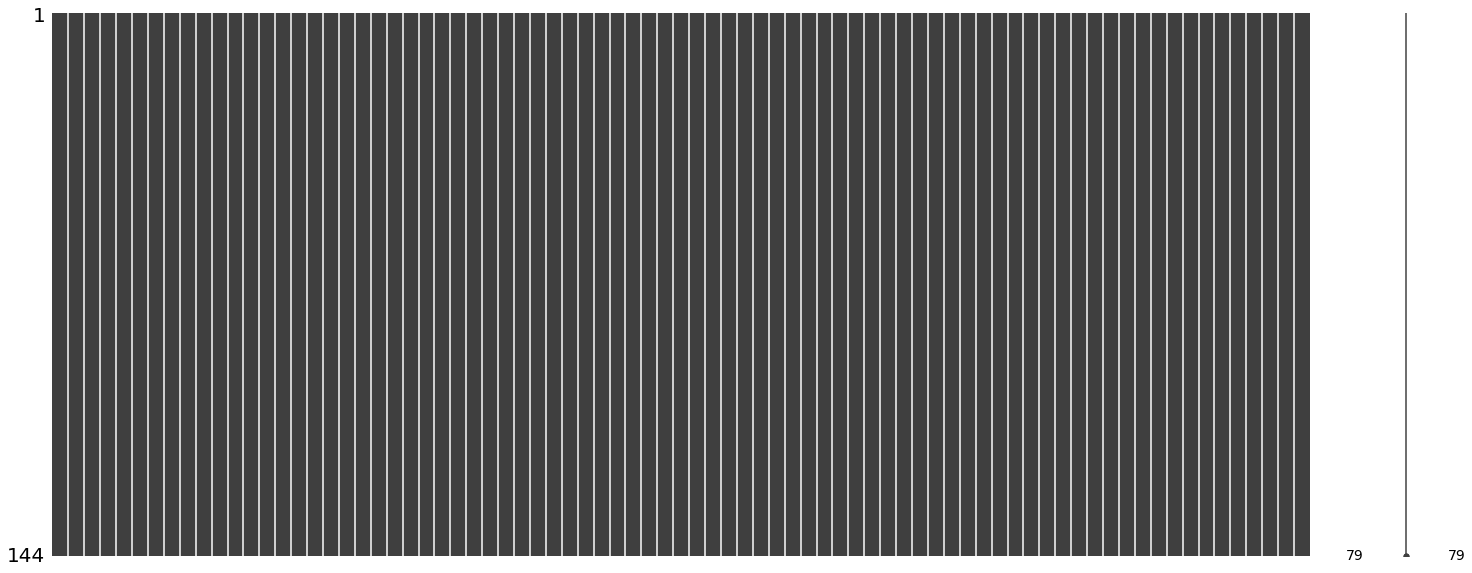

In [2]:
# load data

combined_data1 = pd.read_csv("./data/old_08-19_combined.csv")
combined_data = pd.read_csv("./data/old_08-19_combined.csv", index_col = [0])
only_y = pd.read_csv("./data/08-19_only_y.csv")
no_out = pd.read_csv("./data/no_out.csv")

combined_data.index = pd.to_datetime(combined_data.index)
combined_data1["month"] = pd.to_datetime(combined_data1["month"])

print(combined_data.shape)
print(combined_data1.shape)


msno.matrix(combined_data)

In [4]:
#Check number of rows and columns, type of each columns
#combined_data.info()
#combined_data1.info()

In [5]:
# Understanding the numeric fields
combined_data.describe()

aus_population_natural_increase  aus_population_overseas_arrivals  \
count                       144.000000                        144.000000   
mean                         12.754167                         40.662500   
std                           1.007029                          6.868158   
min                          10.100000                         15.100000   
25%                          12.100000                         36.725000   
50%                          12.750000                         40.600000   
75%                          13.400000                         44.250000   
max                          14.700000                         54.200000   

       aus_population_net overseas migration  \
count                             144.000000   
mean                               18.850000   
std                                 5.537034   
min                                10.100000   
25%                                14.200000   
50%                                17.950000   
75%                                23.325000   
max                                31.100000   

       aus_population_estimated resident population  \
count                                    144.000000   
mean                                   23286.761806   
std                                     1287.157760   
min                                    21016.100000   
25%                                    22166.825000   
50%                                    23284.850000   
75%                                    24367.275000   
max                                    25523.900000   

       aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
count                   144.000000                    144.000000   
mean                    711.716667                     22.079167   
std                      57.914009                      0.863225   
min                     618.400000                     20.500000   
25%                     671.075000                     21.700000   
50%                     710.050000                     22.100000   
75%                     727.300000                     22.500000   
max                     842.100000                     23.600000   

       aus_beef&veal_production  aus_beef&veal_exports  \
count                144.000000             144.000000   
mean                 188.258333             134.287500   
std                   14.230792              15.806495   
min                  172.400000             114.800000   
25%                  176.900000             120.300000   
50%                  186.500000             128.300000   
75%                  196.000000             147.400000   
max                  221.800000             167.400000   

       aus_apparent consumption  australia cattle numbers  ...  \
count                144.000000                144.000000  ...   
mean                  53.920833              27122.916667  ...   
std                    4.503889               1531.622530  ...   
min                   42.500000              24723.000000  ...   
25%                   49.800000              26176.000000  ...   
50%                   54.400000              27367.000000  ...   
75%                   57.800000              28440.000000  ...   
max                   60.400000              29291.000000  ...   

       us_fed_avg_dressed_cows  us_fed_avg_dressed_bulls and stags  \
count               144.000000                          144.000000   
mean                624.409722                          886.604167   
std                  19.559275                           18.250862   
min                 579.000000                          851.000000   
25%                 607.750000                          874.000000   
50%                 625.500000                          884.500000   
75%                 638.000000                          898.000000   
max                 666.000000                          934.000000   

       us_fed_avg_dressed_calve

- Here as you can notice mean value is more than median value of most columns which is represented by 50%(50th percentile) in index column.

- There is notably a big difference between 75th percentile and max values of certain fields like “First hand sales quantity”,”First hand sales amount”,”Total completions” etc.

- Thus observations 1 and 2 suggests that there are extreme values-Outliers in our data set. We get the same conclusion once we look at the histograms of all the numeric fields.

### Checking time series properties of target variable y


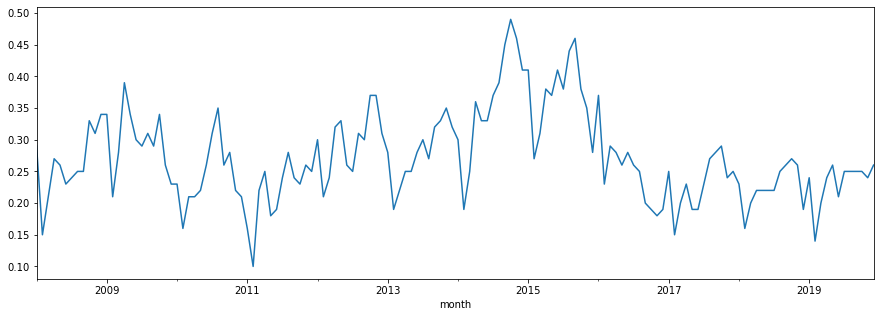

In [6]:
# plot the import ratio trend
_ = combined_data['import_ratio'].plot(figsize=(15, 5))

#color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
#_ = only_y.plot(style='.', figsize=(15,5), color=color_pal[0], title='Import Ratio')



In [7]:
# check if stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(combined_data.import_ratio.dropna())
print('p-value: %f' % result[1])

# 0.164061
#Since the p-value is over 0.05, the data is not stationary

p-value: 0.164061


## Change column type

In [8]:
# steer and us_import got object type, so we need to convert it to float which is a type we need for later
combined_data["us_livestock_commercial_steers"] = pd.to_numeric(combined_data.us_livestock_commercial_steers, errors='coerce')
#combined_data["us_livestock_commercial_steers"]
combined_data["total_us_imports"] = pd.to_numeric(combined_data.total_us_imports, errors='coerce')
#combined_data["total_us_imports"]

combined_data1["us_livestock_commercial_steers"] = pd.to_numeric(combined_data1.us_livestock_commercial_steers, errors='coerce')
#combined_data["us_livestock_commercial_steers"]
combined_data1["total_us_imports"] = pd.to_numeric(combined_data1.total_us_imports, errors='coerce')
#combined_data["total_us_imports"]

# get the col type
a = combined_data.columns.to_series().groupby(combined_data.dtypes).groups
b = combined_data1.columns.to_series().groupby(combined_data1.dtypes).groups
#b


# check a specific col type
#c = combined_data.iloc[:,45:48]
#c.dtypes



## Feature Engineering

refers to the process of creating new variables from existing ones which capture hidden business insights

### Lag features 
- are values at prior time steps
- the features have a lagged impact on the target variable
- The best way to find the optimal number of lags to chose for each field is to look at cross correlation graphs.
- Cross correlation graphs show the correlation between the target variable with various lags of raw features

In [9]:
# Check Optimal Number of Lags
#for i in range(len(no_month_df.columns)-3):
#    plt.figure(i, figsize=(15,2)) # add this statement before your plot
#    plt.xcorr(no_month_df.iloc[:,78],no_month_df.iloc[:,i],maxlags=45, usevlines=1)
#    plt.title(no_month_df.columns[78] + ' & '+ no_month_df.columns[i])
#    plt.show()

In [10]:
def lag_feature(df, lags, new_df_col, target_col):
    tmp = df[new_df_col]
    for i in lags:
        tmp[target_col+'_lag_'+str(i)] = df[target_col].shift(i)
    
    tmp[target_col] = df[target_col]
    return tmp

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

## Now we have the data ready for modeling


## Train/Test Split
### Cut off the data after 2018 to use as our tes set. 



In [13]:
# no month: combine_data
test_df = combined_data.iloc[132:144,:]
train_df = combined_data.iloc[:132,:]
X_train, y_train = train_df.iloc[:,:76], train_df.iloc[:,78]
X_test, y_test = test_df.iloc[:,:76], test_df.iloc[:,78]

# Scale the features
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

# has month: combine_data1
test_df1 = combined_data1.iloc[132:144,:]
train_df1 = combined_data1.iloc[:132,:]
X_train1, y_train1 = train_df1.iloc[:,:77], train_df1.iloc[:,79]
X_test1, y_test1 = test_df1.iloc[:,:77], test_df1.iloc[:,79]
X_test

aus_population_natural_increase  aus_population_overseas_arrivals  \
month                                                                           
2019-01-01                             12.7                              51.1   
2019-02-01                             12.7                              51.1   
2019-03-01                             12.7                              51.1   
2019-04-01                             11.5                              41.5   
2019-05-01                             11.5                              41.5   
2019-06-01                             11.5                              41.5   
2019-07-01                             10.8                              54.2   
2019-08-01                             10.8                              54.2   
2019-09-01                             10.8                              54.2   
2019-10-01                             11.4                              50.7   
2019-11-01                             11.4                              50.7   
2019-12-01                             11.4                              50.7   

            aus_population_net overseas migration  \
month                                               
2019-01-01                                   20.9   
2019-02-01                                   20.9   
2019-03-01                                   20.9   
2019-04-01                                   12.7   
2019-05-01                                   12.7   
2019-06-01                                   12.7   
2019-07-01                                   24.8   
2019-08-01                                   24.8   
2019-09-01                                   24.8   
2019-10-01                                   14.3   
2019-11-01                                   14.3   
2019-12-01                                   14.3   

            aus_population_estimated resident population  \
month                                                      
2019-01-01                                       25171.3   
2019-02-01                                       25211.9   
2019-03-01                                       25252.4   
2019-04-01                                       25293.0   
2019-05-01                                       25317.2   
2019-06-01                                       25341.5   
2019-07-01                                       25365.7   
2019-08-01                                       25401.3   
2019-09-01                                       25436.8   
2019-10-01                                       25472.4   
2019-11-01                                       25498.1   
2019-12-01                                       25523.9   

            aus_beef&veal_slaughterings  aus_beef&veal_average weight  \
month                                                                   
2019-01-01                        725.3                          22.5   
2019-02-01                        725.3                          22.5   
2019-03-01                        725.3                          22.5   
2019-04-01                        725.3                          22.5   
2019-05-01                        725.3                          22.5   
2019-06-01                        725.3                          22.5   
2019-07-01                        724.9                          22.8   
2019-08-01                        724.9                          22.8   
2019-09-01                        724.9                          22.8   
2019-10-01                        724.9                          22.8   
2019-11-01                        724.9                          22.8   
2019-12-01                        724.9                          22.8   

            aus_beef&veal_production  aus_beef&veal_exports  \
month                                                         
2019-01-01                     196.0                  147.6   
2019-02-01                     196.0                  147.6   
2019-03-01        

We tune a set of 8 parameters for this model: 
- number of gradient boosted trees, 
- maximum tree depth for base learners, 
- boosting learning rate, 
- minimum loss reduction required to make a further partition on a leaf node 
- minimum sum of weights of all observations required in a child node
- subsample
- colsample_bytree

In [14]:
xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['outlier','n_estimators','max_depth','min_child_weight',
                                                 'gamma','learning_rate','subsample','colsample_bytree',
                                                 'eta','Train Accurcay','Test Accurcay', 'RMSE','MAE'])

In [ ]:
100%|██████████| 2000/2000 [17:43<00:00,  1.88trial/s, best loss: 0.010083713105918275]
The best hyperparameters are :  

{'colsample_bytree': 0.9603712581568464, 'learning_rate': 0.5770106971394201, 
 'max_depth': 11.0, 'min_child_weight': 7.0, 'n_estimators': 715.0, 'subsample': 0.6155665901504644}

In [15]:
outlier = 'all_yes'

# Number of trees
n_estimators = 715

# Maximum number of levels in tree
max_depth = 11

#minimum sum of weights of all observations required in a child
min_child_weight = 7

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.5770106971394201
subsample = 0.6155665901504644 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9603712581568464 # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

# better simple version
xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#model_all_yes= xgb_reg.fit(X_train, y_train)

evaluation = [(X_train, y_train), (X_test, y_test)]
model_all_yes = xgb_reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(X_train)
#predictions_train = xgb_reg.predict(X_train_no_outlier)

# Calculate the absolute errors
errors_train = abs(predictions_train - y_train)
#errors_train = abs(predictions_train - y_train_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ y_train)
#mape_train = 100 * (errors_train/ y_train_no_outlier)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_test)
#predictions_test = xgb_reg.predict(X_test_no_outlier)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_test)
#errors_test = abs(predictions_test - y_test_no_outlier)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_test)
#mape_test = 100 * (errors_test/ y_test_no_outlier)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)



xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(X_test)

test_df['predictions'] = predictions
test_df1['predictions'] = predictions


# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0  all_yes          715        11                7     0       0.577011   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.615567          0.960371  0.1       96.130904      96.256395  0.010084   

        MAE  
0  0.008069

In [16]:
np.mean(mape_test)

3.743604697532706

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(X_train, y_train)

    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    xgb_reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 2000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

### Feature Selection
- based on feature score from xgboost
- based on shap value

In [37]:
X_train.shape 
# there are 76 features in total
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  learning_rate  \
0  all_yes          715        11                7     0       0.577011   

   subsample  colsample_bytree  eta  Train Accurcay  Test Accurcay      RMSE  \
0   0.615567          0.960371  0.1       96.130904      96.256395  0.010084   

        MAE  
0  0.008069

## Featuer Selection Using XGBoost Feature Importance

In [57]:
### Based on Feature score from XGBoost (Gain)
from numpy import sort
from sklearn.feature_selection import SelectFromModel


thresholds = sort(model_all_yes.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_all_yes, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    
    # train model
    selection_model = xgb.XGBRegressor()
    #selection_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    #                               max_depth = max_depth, min_child_weight = min_child_weight,
    #                               gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
    #                               eta = eta, seed = seed)
    
    #selection_model.fit(select_X_train, y_train)
    
    evaluation = [(select_X_train, y_train), (select_X_test, y_test)]
    
    selection_model.fit(select_X_train, y_train,
                        eval_set=evaluation, eval_metric="rmse",
                        early_stopping_rounds=10,verbose=False)
    
    # eval model
    #select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    
    #accuracy = accuracy_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    errors_test = abs(y_pred - y_test)
    mape_test = 100 * (errors_test/ y_test)
    mape = np.mean(mape_test)
    
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Thresh=%.8f, n=%d, RMSE: %.8f, MAE: %.8f, MAPE: %.8f" % (thresh, select_X_train.shape[1], rmse, mae, mape))

Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE: 27.72684232
Thresh=0.00000000, n=76, RMSE: 0.06740228, MAE: 0.05954991, MAPE

In [58]:
importances = list(zip(model_all_yes.feature_importances_, X_train.columns))
importances.sort(reverse=True)
pd.DataFrame(importances).to_csv('6m_xgboost_importance.csv')
importances

[(0.20186819, 'us_commercial_avg_live_calves'),
 (0.1776292, 'aus_exports of beef, veal and live cattle to US'),
 (0.11560643, 'us_total red meat and poultry'),
 (0.07966247, 'us_fed_avg_dressed_steers'),
 (0.049734555, 'aus_beef&veal_slaughterings'),
 (0.03961352, 'us_veganism'),
 (0.033216573, 'aus_total dairy cattle and calves'),
 (0.020051638, 'us_livestock_commercial_mature sheep'),
 (0.0147348745, 'australia cattle numbers'),
 (0.014322042, 'us_production_commercial_total red meat'),
 (0.013985354, 'us_livestock_commercial_dairy'),
 (0.013965692, 'us_veganism_trend_ratio'),
 (0.013342384,
  'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)'),
 (0.01329065, 'us_cold_storage_beef'),
 (0.012611309, 'aus_beef&veal_production'),
 (0.011572365, 'aus_max_temp'),
 (0.011201526, 'us_beef'),
 (0.010558126, 'us_livestock_fedral_inspected_dairy_cows'),
 (0.010124564, 'aus_population_natural_increase'),
 (0.009825678, 'us_fed_avg_dressed_heifers'),
 (0.0090485355,

In [59]:
x = model_all_yes.get_booster().get_score(importance_type = "gain")
sortedx = {k:v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
np.array([k for k, v in sortedx.items()])

array(['us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
       'aus_beef&veal_slaughterings', 'us_veganism',
       'aus_total dairy cattle and calves',
       'us_livestock_commercial_mature sheep', 'australia cattle numbers',
       'us_production_commercial_total red meat',
       'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',
       'us_beef', 'us_livestock_fedral_inspected_dairy_cows',
       'aus_population_natural_increase', 'us_fed_avg_dressed_heifers',
       'us_cold_storage_veal', 'us_livestock_commercial_cattle',
       'us_livestock_fedral_inspected_bulls and stags',
       'us_livestock_commercial_bulls and stags',
       'aus_population_estimated resident population',
       'aus_Meat Prod

In [60]:
a = ['us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
       'aus_beef&veal_slaughterings', 'us_veganism',
       'aus_total dairy cattle and calves',
       'us_livestock_commercial_mature sheep', 'australia cattle numbers',
       'us_production_commercial_total red meat',
       'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',
       'us_beef','us_livestock_fedral_inspected_dairy_cows']
len(a)

17

### Refit Model with selected features 

In [14]:
# create subdf from original dataset

xgb_selected_features_18 = ['us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
       'aus_beef&veal_slaughterings', 'us_veganism',
       'aus_total dairy cattle and calves',
       'us_livestock_commercial_mature sheep', 'australia cattle numbers',
       'us_production_commercial_total red meat',
       'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',
       'us_beef','us_livestock_fedral_inspected_dairy_cows', 'import_ratio']


xgb_selected_features_18_month = ['month','us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
       'aus_beef&veal_slaughterings', 'us_veganism',
       'aus_total dairy cattle and calves',
       'us_livestock_commercial_mature sheep', 'australia cattle numbers',
       'us_production_commercial_total red meat',
       'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',
       'us_beef','us_livestock_fedral_inspected_dairy_cows', 'import_ratio']


xgb_selected_features_17 = ['us_commercial_avg_live_calves',
                            'aus_exports of beef, veal and live cattle to US',
                            'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
                            'aus_beef&veal_slaughterings', 'us_veganism',       
                            'aus_total dairy cattle and calves',       
                            'us_livestock_commercial_mature sheep', 
                            'australia cattle numbers',       
                            'us_production_commercial_total red meat',       
                            'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',       
                            'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',       
                            'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',       
                            'us_beef', 'import_ratio']


xgb_selected_features_17_month = ['month','us_commercial_avg_live_calves',
       'aus_exports of beef, veal and live cattle to US',
       'us_total red meat and poultry', 'us_fed_avg_dressed_steers',
       'aus_beef&veal_slaughterings', 'us_veganism',
       'aus_total dairy cattle and calves',
       'us_livestock_commercial_mature sheep', 'australia cattle numbers',
       'us_production_commercial_total red meat',
       'us_livestock_commercial_dairy', 'us_veganism_trend_ratio',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'us_cold_storage_beef', 'aus_beef&veal_production', 'aus_max_temp',
       'us_beef', 'import_ratio']



# select from original data
# no month: combine_data
xgb_selected_df = combined_data[xgb_selected_features_17]
idx = xgb_selected_df.shape[1]-1
xgb_selected_test_df = xgb_selected_df.iloc[132:144,:]
xgb_selected_train_df = xgb_selected_df.iloc[:132,:]

xgb_selected_X_train, xgb_selected_y_train = xgb_selected_train_df.iloc[:,:idx], xgb_selected_train_df.iloc[:,idx]
xgb_selected_X_test, xgb_selected_y_test = xgb_selected_test_df.iloc[:,:idx], xgb_selected_test_df.iloc[:,idx]



# has month: combine_data1
xgb_selected_df1 = combined_data1[xgb_selected_features_17_month]
idx1 = xgb_selected_df1.shape[1]-1
xgb_selected_test_df1 = xgb_selected_df1.iloc[132:144,:]
xgb_selected_train_df1 = xgb_selected_df1.iloc[:132,:]

xgb_selected_X_train1, xgb_selected_y_train1 = xgb_selected_train_df1.iloc[:,:idx1], xgb_selected_train_df1.iloc[:,idx1]
xgb_selected_X_test1, xgb_selected_y_test1 = xgb_selected_test_df1.iloc[:,:idx1], xgb_selected_test_df1.iloc[:,idx1]
xgb_selected_X_test1



month  us_commercial_avg_live_calves  \
132 2019-01-01                            212   
133 2019-02-01                            220   
134 2019-03-01                            219   
135 2019-04-01                            241   
136 2019-05-01                            235   
137 2019-06-01                            223   
138 2019-07-01                            205   
139 2019-08-01                            206   
140 2019-09-01                            216   
141 2019-10-01                            222   
142 2019-11-01                            227   
143 2019-12-01                            228   

     aus_exports of beef, veal and live cattle to US  \
132                                             20.1   
133                                             20.1   
134                                             20.1   
135                                             20.1   
136                                             20.1   
137                                             20.1   
138                                             20.0   
139                                             20.0   
140                                             20.0   
141                                             20.0   
142                                             20.0   
143                                             20.0   

     us_total red meat and poultry  us_fed_avg_dressed_steers  \
132                           18.7                        886   
133                           18.7                        879   
134                           18.7                        867   
135                           18.7                        859   
136                           18.7                        847   
137                           18.7                        851   
138                           18.7                        866   
139                           18.7                        881   
140                           18.7                        894   
141                           18.7                        902   
142                           18.7                        911   
143                           18.7                        905   

     aus_beef&veal_slaughterings  us_veganism  \
132                        725.3           81   
133                        725.3           80   
134                        725.3           76   
135                        725.3           77   
136                        725.3           73   
137                        725.3           78   
138                        724.9           74   
139                        724.9           80   
140                        724.9           75   
141                        724.9           80   
142                        724.9          100   
143                        724.9           96   

     aus_total dairy cattle and calves  us_livestock_commercial_mature sheep  \
132                               2341                                  9.26   
133                               2341                                  8.08   
134                               2341                                  9.28   
135                               2341                                 13.02   
136                               2341                                 12.58   
137                               2341                                 10.18   
138                               2341                                 11.60   
139                               2341                                 12.91   
140                               2341                                 11.01   
141                               2341                                 11.34   
142                               2341                                 11.16   
143                               2341                                 11.71   

     australia cattle numbers  us_production_commercial_total red meat  \
132                     24723              

In [ ]:
xgb_17
100%|██████████| 3000/3000 [27:32<00:00,  1.82trial/s, best loss: 0.01227253835716706] 
The best hyperparameters are :  

{'colsample_bytree': 0.9236675422139483, 'learning_rate': 0.6123120778222756, 
 'max_depth': 10.0, 'min_child_weight': 3.0, 'n_estimators': 1552.0, 'subsample': 0.7992834166181835}

In [15]:
outlier = '17_xgb_sel_yes'

## Parameter Setting

# Number of trees
n_estimators = 1552

# Maximum number of levels in tree
max_depth = 10

#minimum sum of weights of all observations required in a child
min_child_weight = 3

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6123120778222756
subsample = 0.7992834166181835 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9236675422139483  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_sel_yes= xgb_reg.fit(selected_X_train, selected_y_train)

evaluation = [(xgb_selected_X_train, xgb_selected_y_train), (xgb_selected_X_test, xgb_selected_y_test)]
model_xgb_sel_yes = xgb_reg.fit(xgb_selected_X_train, xgb_selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(xgb_selected_X_train)

# Calculate the absolute errors
errors_train = abs(predictions_train - xgb_selected_y_train)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ xgb_selected_y_train)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(xgb_selected_X_test)

# Calculate the absolute errors
errors_test = abs(predictions_test - xgb_selected_y_test)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ xgb_selected_y_test)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(xgb_selected_X_test)

xgb_selected_test_df['predictions'] = predictions
xgb_selected_test_df1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(xgb_selected_y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(xgb_selected_y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
print(round(np.mean(mape_test),6))
xgb_Test_Accuracy_Data

4.725708


outlier n_estimators max_depth min_child_weight gamma  \
0  17_xgb_sel_yes         1552        10                3     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.612312   0.799283          0.923668  0.1       96.780878   

   Test Accurcay      RMSE       MAE  
0      95.274292  0.012273  0.009945

In [70]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(selected_X_train, selected_y_train)
    #predictions = xgb_reg.predict(selected_X_test)

    evaluation = [(xgb_selected_X_train, xgb_selected_y_train), (xgb_selected_X_test, xgb_selected_y_test)]
    
    xgb_reg.fit(xgb_selected_X_train, xgb_selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(xgb_selected_X_test)
    rmse = np.sqrt(mean_squared_error(xgb_selected_y_test, predictions))
    mae = mean_absolute_error(xgb_selected_y_test, predictions)
    #mse= mean_squared_error(selected_y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 3000/3000 [27:32<00:00,  1.82trial/s, best loss: 0.01227253835716706] 
The best hyperparameters are :  

{'colsample_bytree': 0.9236675422139483, 'learning_rate': 0.6123120778222756, 'max_depth': 10.0, 'min_child_weight': 3.0, 'n_estimators': 1552.0, 'subsample': 0.7992834166181835}


In [ ]:
xgb_17
100%|██████████| 3000/3000 [27:32<00:00,  1.82trial/s, best loss: 0.01227253835716706] 
The best hyperparameters are :  

{'colsample_bytree': 0.9236675422139483, 'learning_rate': 0.6123120778222756, 
 'max_depth': 10.0, 'min_child_weight': 3.0, 'n_estimators': 1552.0, 'subsample': 0.7992834166181835}

In [66]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes          715        11                7     0   
0  shap_10_sel_yes          206        15                3     0   
0  best10_lag1_yes          518        15                1     0   
0  best10_lag1_yes          518        15                1     0   
0         2016vali          518        15                1     0   
0         2016vali          518        15                1     0   
0  best10_lag1_yes          518        15                1     0   
0          all_yes          715        11                7     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.577011   0.615567          0.960371  0.1       96.130904   
0       0.357244   0.200138          0.652253  0.1       93.305433   
0       0.680241   0.608388          0.817915  0.1       97.600410   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.680241   0.608388          0.817915  0.1       99.859364   
0       0.680241   0.608388          0.817915  0.1       99.859364   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.577011   0.615567          0.960371  0.1       96.130904   

   Test Accurcay      RMSE       MAE  
0      96.256395  0.010084  0.008069  
0      97.244769  0.007440  0.005993  
0      86.601409  0.038220  0.025555  
0      97.519906  0.006415  0.005216  
0      99.857779  0.000452  0.000371  
0      99.857779  0.000452  0.000371  
0      97.519906  0.006415  0.005216  
0      96.256395  0.010084  0.008069

## Featuer Selection Using SHAP

In [38]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(model_all_yes, X_test)

features = np.array(out1["features"])
importance = np.array(out1["importance"])
sig_features = []
for i in range(len(out1)):
    if importance[i] != 0.0:
        sig_features.append(features[i])
        
print(len(sig_features))
sig_features

40


['aus_exports of beef, veal and live cattle to US',
 'aus_total dairy cattle and calves',
 'us_production_commercial_total red meat',
 'us_commercial_avg_live_calves',
 'us_production_fedral_inspected_total poultry',
 'aus_avg_rainfall',
 'aus_beef&veal_slaughterings',
 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
 'us_veganism_trend_ratio',
 'us_veganism',
 'us_livestock_commercial_cattle',
 'us_total red meat and poultry',
 'us_livestock_fedral_inspected_bulls and stags',
 'us_beef',
 'us_fed_avg_dressed_steers',
 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)',
 'aus_population_overseas_arrivals',
 'us_cold_storage_beef',
 'us_livestock_commercial_bulls and stags',
 'aus_population_estimated resident population',
 'australia cattle numbers',
 'us_livestock_commercial_dairy',
 'us_livestock_commercial_beef',
 'aus_Meat Produced ;  CALVES ;  Total (State) ;',
 'us_livestock_fedral_inspected_dairy_cows',
 'a

In [26]:
model_BorutaShap_model = XGBRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_BorutaShap_model,
                              importance_measure='shap',
                              classification=False)

#Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False,
#                     train_or_test = 'test', verbose=True, random_state = 517)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, verbose=True, random_state = 517)

  0%|          | 0/100 [00:00<?, ?it/s]

9 attributes confirmed important: ['aus_beef&veal_slaughterings', 'aus_population_natural_increase', 'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry', 'aus_exports of beef, veal and live cattle to US', 'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef', 'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves']
66 attributes confirmed unimportant: ['aus_feed', 'us_livestock_commercial_bulls and stags', 'us_commercial_avg_live_calves', 'us_fed_avg_dressed_bulls and stags', 'us cattle numbers(*1000)', 'us_production_fedral_inspected_veal', 'us_livestock_commercial_cattle', 'us_production_commercial_veal', 'us_fed_avg_dressed_cows', 'aus_pasture', 'us_income per capita', 'us_production_commercial_total red meat', 'us import of beef kt (cw)', 'us_commercial_avg_live_cattle', 'aus_state_rd', 'us_livestock_fedral_inspected_dairy_cows', 'us beef Per Capita Consumption', 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally

In [17]:
selected_features_shap_all = ['aus_exports of beef, veal and live cattle to US',
                              'aus_total dairy cattle and calves',
                              'us_production_commercial_total red meat',
                              'us_commercial_avg_live_calves', 'us_production_fedral_inspected_total poultry',
                              'aus_avg_rainfall', 'aus_beef&veal_slaughterings',
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                              'us_veganism_trend_ratio',
                              'us_veganism', 'us_livestock_commercial_cattle', 'us_total red meat and poultry',
                              'us_livestock_fedral_inspected_bulls and stags', 'us_beef',
                              'us_fed_avg_dressed_steers', 
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 
                              'aus_population_overseas_arrivals', 'us_cold_storage_beef', 
                              'us_livestock_commercial_bulls and stags', 'aus_population_estimated resident population', 
                              'australia cattle numbers', 'us_livestock_commercial_dairy',
                              'us_livestock_commercial_beef', 'aus_Meat Produced ;  CALVES ;  Total (State) ;', 
                              'us_livestock_fedral_inspected_dairy_cows', 'aus_population_net overseas migration', 
                              'aus_min_temp', 'aus_max_temp', 'us_livestock_fedral_inspected_beef', 
                              'us_fed_avg_dressed_heifers', 'us_cold_storage_veal', 'us_livestock_commercial_mature sheep',
                              'us_livestock_commercial_steers', 'aus_beef&veal_production', 'aus_fed_rd',
                              'us_livestock_commercial_lambs and yearlings', 'aus_population_natural_increase',
                              'us_livestock_commercial_heifers', 'us_commercial_avg_live_cattle', 
                              'us_production_fedral_inspected_total red meat',
                              'import_ratio']

selected_features_shap_month_all = ['month','aus_exports of beef, veal and live cattle to US',
                              'aus_total dairy cattle and calves',
                              'us_production_commercial_total red meat',
                              'us_commercial_avg_live_calves', 'us_production_fedral_inspected_total poultry',
                              'aus_avg_rainfall', 'aus_beef&veal_slaughterings',
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                              'us_veganism_trend_ratio',
                              'us_veganism', 'us_livestock_commercial_cattle', 'us_total red meat and poultry',
                              'us_livestock_fedral_inspected_bulls and stags', 'us_beef',
                              'us_fed_avg_dressed_steers', 
                              'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 
                              'aus_population_overseas_arrivals', 'us_cold_storage_beef', 
                              'us_livestock_commercial_bulls and stags', 'aus_population_estimated resident population', 
                              'australia cattle numbers', 'us_livestock_commercial_dairy',
                              'us_livestock_commercial_beef', 'aus_Meat Produced ;  CALVES ;  Total (State) ;', 
                              'us_livestock_fedral_inspected_dairy_cows', 'aus_population_net overseas migration', 
                              'aus_min_temp', 'aus_max_temp', 'us_livestock_fedral_inspected_beef', 
                              'us_fed_avg_dressed_heifers', 'us_cold_storage_veal', 'us_livestock_commercial_mature sheep',
                              'us_livestock_commercial_steers', 'aus_beef&veal_production', 'aus_fed_rd',
                              'us_livestock_commercial_lambs and yearlings', 'aus_population_natural_increase',
                              'us_livestock_commercial_heifers', 'us_commercial_avg_live_cattle', 
                              'us_production_fedral_inspected_total red meat',
                              'import_ratio']



selected_features_shap_9 = ['aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','import_ratio']

selected_features_shap_month_9 = ['month','aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','import_ratio']


selected_features_shap_10 = ['aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism','import_ratio']

selected_features_shap_month_10 = ['month','aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism','import_ratio']

# select from original data
# no month: combine_data

selected_df = combined_data[selected_features_shap_10]
idx = selected_df.shape[1]-1
selected_test_df = selected_df.iloc[132:144,:]
selected_train_df = selected_df.iloc[:132,:]

selected_X_train, selected_y_train = selected_train_df.iloc[:,:idx], selected_train_df.iloc[:,idx]
selected_X_test, selected_y_test = selected_test_df.iloc[:,:idx], selected_test_df.iloc[:,idx]


# has month: combine_data1
selected_df1 = combined_data1[selected_features_shap_month_10]
idx1 = selected_df1.shape[1]-1
selected_test_df1 = selected_df1.iloc[132:144,:]
selected_train_df1 = selected_df1.iloc[:132,:]

selected_X_train1, selected_y_train1 = selected_train_df1.iloc[:,:idx1], selected_train_df1.iloc[:,idx1]
selected_X_test1, selected_y_test1 = selected_test_df1.iloc[:,:idx1], selected_test_df1.iloc[:,idx1]
selected_X_test1


month  aus_beef&veal_slaughterings  aus_population_natural_increase  \
132 2019-01-01                        725.3                             12.7   
133 2019-02-01                        725.3                             12.7   
134 2019-03-01                        725.3                             12.7   
135 2019-04-01                        725.3                             11.5   
136 2019-05-01                        725.3                             11.5   
137 2019-06-01                        725.3                             11.5   
138 2019-07-01                        724.9                             10.8   
139 2019-08-01                        724.9                             10.8   
140 2019-09-01                        724.9                             10.8   
141 2019-10-01                        724.9                             11.4   
142 2019-11-01                        724.9                             11.4   
143 2019-12-01                        724.9                             11.4   

     aus_beef&veal_exports  \
132                  147.6   
133                  147.6   
134                  147.6   
135                  147.6   
136                  147.6   
137                  147.6   
138                  155.1   
139                  155.1   
140                  155.1   
141                  155.1   
142                  155.1   
143                  155.1   

     us_production_fedral_inspected_total red meat and poultry  \
132                                            8939.67           
133                                            7906.65           
134                                            8334.81           
135                                            8640.05           
136                                            8905.95           
137                                            8391.32           
138                                            8970.29           
139                                            9016.33           
140                                            8602.12           
141                                            9726.97           
142                                            8657.12           
143                                            8838.28           

     aus_exports of beef, veal and live cattle to US  \
132                                             20.1   
133                                             20.1   
134                                             20.1   
135                                             20.1   
136                                             20.1   
137                                             20.1   
138                                             20.0   
139                                             20.0   
140                                             20.0   
141                                             20.0   
142                                             20.0   
143                                             20.0   

     us_livestock_commercial_mature sheep  us_livestock_commercial_beef  \
132                                  9.26                        261.90   
133                                  8.08                        228.68   
134                                  9.28                        251.74   
135                                 13.02                        271.19   
136                                 12.58                        271.71   
137                                 10.18                        262.57   
138                                 11.60                        266.56   
139                                 12.91                        265.32   
140                                 11.01                        258.27   
141                                 11.34                        313.33   
142                                 11.16                        298.08   
143                                 11.71                        287.52   

     us_vegan

In [ ]:
shap all
100%|██████████| 3000/3000 [25:10<00:00,  1.99trial/s, best loss: 0.007569717276293454]  
The best hyperparameters are :  

{'colsample_bytree': 0.523640199279704, 'learning_rate': 0.7113987595250908,
 'max_depth': 12.0, 'min_child_weight': 9.0, 'n_estimators': 489.0, 'subsample': 0.7802219304338632}

In [ ]:
100%|██████████| 3000/3000 [20:47<00:00,  2.40trial/s, best loss: 0.0074401913736625224]
The best hyperparameters are :  

{'colsample_bytree': 0.6522526338963393, 'learning_rate': 0.3572435914157277, 
 'max_depth': 15.0, 'min_child_weight': 3.0, 'n_estimators': 206.0, 'subsample': 0.2001382655665839}

In [18]:
outlier = 'shap_10_sel_yes'

## Parameter Setting

# Number of trees
n_estimators = 206

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 3

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.3572435914157277
subsample = 0.2001382655665839 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.6522526338963393  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_shap_sel_yes= xgb_reg.fit(selected_X_train, selected_y_train)

evaluation = [(selected_X_train, selected_y_train), (selected_X_test, selected_y_test)]
model_shap_sel_yes = xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test)

selected_test_df['predictions'] = predictions
selected_test_df1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)

print(round(np.mean(mape_test),6))
xgb_Test_Accuracy_Data

2.755231


outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes          715        11                7     0   
0  shap_10_sel_yes          206        15                3     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.577011   0.615567          0.960371  0.1       96.130904   
0       0.357244   0.200138          0.652253  0.1       93.305433   

   Test Accurcay      RMSE       MAE  
0      96.256395  0.010084  0.008069  
0      97.244769  0.007440  0.005993

In [22]:
np.mean(mape_test)

2.75523143869362

In [75]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(selected_X_train, selected_y_train)
    #predictions = xgb_reg.predict(selected_X_test)

    evaluation = [( selected_X_train, selected_y_train), (selected_X_test, selected_y_test)]
    
    xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(selected_X_test)
    rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))
    mae = mean_absolute_error(selected_y_test, predictions)
    #mse= mean_squared_error(selected_y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 3000/3000 [25:10<00:00,  1.99trial/s, best loss: 0.007569717276293454]  
The best hyperparameters are :  

{'colsample_bytree': 0.523640199279704, 'learning_rate': 0.7113987595250908, 'max_depth': 12.0, 'min_child_weight': 9.0, 'n_estimators': 489.0, 'subsample': 0.7802219304338632}


In [ ]:
shap all
100%|██████████| 3000/3000 [25:10<00:00,  1.99trial/s, best loss: 0.007569717276293454]  
The best hyperparameters are :  

{'colsample_bytree': 0.523640199279704, 'learning_rate': 0.7113987595250908,
 'max_depth': 12.0, 'min_child_weight': 9.0, 'n_estimators': 489.0, 'subsample': 0.7802219304338632}

In [ ]:
shap 10

100%|██████████| 3000/3000 [20:47<00:00,  2.40trial/s, best loss: 0.0074401913736625224]
The best hyperparameters are :  

{'colsample_bytree': 0.6522526338963393, 'learning_rate': 0.3572435914157277, 
 'max_depth': 15.0, 'min_child_weight': 3.0, 'n_estimators': 206.0, 'subsample': 0.2001382655665839}

In [ ]:
shap 9

100%|██████████| 5000/5000 [1:00:21<00:00,  1.38trial/s, best loss: 0.006084043468343825]
The best hyperparameters are :  

{'colsample_bytree': 0.8719514329040694, 'learning_rate': 0.6378100076455293, 
 'max_depth': 14.0, 'min_child_weight': 5.0, 'n_estimators': 475.0, 'subsample': 0.41210385484171036}

# Found the best model then add lag features

In [46]:
selected_df.shape

(144, 11)

In [21]:
# create lag features for the best subset
lag_list = [1,13]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag



df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

best_test_df_lag = best_lag.iloc[132:144,:]
best_train_df_lag = best_lag.iloc[:132,:]
best_X_train_lag, best_y_train_lag = best_train_df_lag.iloc[:,:stop_idx], best_train_df_lag.iloc[:,stop_idx]
best_X_test_lag, best_y_test_lag = best_test_df_lag.iloc[:,:stop_idx], best_test_df_lag.iloc[:,stop_idx]
# 3lags = 9

# has month: 
stop_idx1 = best_lag1.shape[1]-1

best_test_df1_lag = best_lag1.iloc[132:144,:]
best_train_df1_lag = best_lag1.iloc[:132,:]
best_X_train1_lag, best_y_train1_lag = best_train_df1_lag.iloc[:,:stop_idx1], best_train_df1_lag.iloc[:,stop_idx1]
best_X_test1_lag, best_y_test1_lag = best_test_df1_lag.iloc[:,:stop_idx1], best_test_df1_lag.iloc[:,stop_idx1]
# 3lags = 10

best_X_train_lag

aus_beef&veal_slaughterings  aus_population_natural_increase  \
month                                                                      
2008-01-01                        722.7                             14.0   
2008-02-01                        722.7                             14.0   
2008-03-01                        722.7                             14.0   
2008-04-01                        722.7                             12.6   
2008-05-01                        722.7                             12.6   
...                                 ...                              ...   
2018-08-01                        725.3                             11.1   
2018-09-01                        725.3                             11.1   
2018-10-01                        725.3                             12.0   
2018-11-01                        725.3                             12.0   
2018-12-01                        725.3                             12.0   

            aus_beef&veal_exports  \
month                               
2008-01-01                  120.0   
2008-02-01                  120.0   
2008-03-01                  120.0   
2008-04-01                  120.0   
2008-05-01                  120.0   
...                           ...   
2018-08-01                  147.6   
2018-09-01                  147.6   
2018-10-01                  147.6   
2018-11-01                  147.6   
2018-12-01                  147.6   

            us_production_fedral_inspected_total red meat and poultry  \
month                                                                   
2008-01-01                                            8208.07           
2008-02-01                                            7406.19           
2008-03-01                                            7569.35           
2008-04-01                                            8025.23           
2008-05-01                                            7922.09           
...                                                       ...           
2018-08-01                                            9196.85           
2018-09-01                                            8044.41           
2018-10-01                                            9398.13           
2018-11-01                                            8648.87           
2018-12-01                                            8056.90           

            aus_exports of beef, veal and live cattle to US  \
month                                                         
2008-01-01                                             20.5   
2008-02-01                                             20.5   
2008-03-01                                             20.5   
2008-04-01                                             20.5   
2008-05-01                                             20.5   
...                                                     ...   
2018-08-01                                             20.1   
2018-09-01                                             20.1   
2018-10-01                                             20.1   
2018-11-01                                             20.1   
2018-12-01                                             20.1   

            us_livestock_commercial_mature sheep  \
month                                              
2008-01-01                                  9.62   
2008-02-01                                  9.03   
2008-03-01                                 10.30   
2008-04-01                                 11.11   
2008-05-01                                 12.08   
...                                          ...   
2018-08-01                                 12.39   
2018-09-01                                  9.19   
2018-10-01                                 10.56   
2018-11-01                                  9.87   
2018-12-01                                 11.57   

            us_livestock_commercial_beef  us_veganism_trend_ratio  \
month                    

In [ ]:
1, 12 lag
100%|██████████| 3000/3000 [47:02<00:00,  1.06trial/s, best loss: 0.00806734014852001]   
The best hyperparameters are :  

{'colsample_bytree': 0.8950450429414865, 'learning_rate': 0.22727507403581526, 
 'max_depth': 12.0, 'min_child_weight': 1.0, 'n_estimators': 1014.0, 'subsample': 0.219160512605524}

shap10+1 lags

100%|██████████| 3000/3000 [21:00<00:00,  2.38trial/s, best loss: 0.006415122973785496]
The best hyperparameters are :  

{'colsample_bytree': 0.8179152785753151, 'learning_rate': 0.6802414794084608, 
 'max_depth': 15.0, 'min_child_weight': 1.0, 'n_estimators': 518.0, 'subsample': 0.6083882361120225}


In [ ]:
1,13 lag
100%|██████████| 3000/3000 [46:57<00:00,  1.06trial/s, best loss: 0.008650083384536331] 
The best hyperparameters are :  

{'colsample_bytree': 0.9997425331849654, 'learning_rate': 0.29107153449309575, 
 'max_depth': 15.0, 'min_child_weight': 0.0, 'n_estimators': 2248.0, 'subsample': 0.23795409084301097}

In [23]:
outlier = 'best10_lag113_yes'

## Parameter Setting

# Number of trees
n_estimators = 2248

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 0

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.29107153449309575
subsample = 0.23795409084301097 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.9997425331849654  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
best_model = xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(best_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - best_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ best_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(best_X_test_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - best_y_test_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ best_y_test_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(best_X_test_lag)

best_test_df_lag['predictions'] = predictions
best_test_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(best_y_test_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0            all_yes          715        11                7     0   
0    shap_10_sel_yes          206        15                3     0   
0    best10_lag1_yes          518        15                1     0   
0  best10_lag113_yes         2248        15                0     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.577011   0.615567          0.960371  0.1       96.130904   
0       0.357244   0.200138          0.652253  0.1       93.305433   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.291072   0.237954          0.999743  0.1       93.475060   

   Test Accurcay      RMSE       MAE  
0      96.256395  0.010084  0.008069  
0      97.244769  0.007440  0.005993  
0      97.519906  0.006415  0.005216  
0      97.203901  0.008650  0.006601

In [24]:
round(np.mean(mape_test),6)

2.796099

In [40]:
e = best_y_train_lag - predictions_train

pd.DataFrame(e).to_csv("no_competitor_12m_redsidual_2008-2018_Dec.csv")

In [22]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(best_X_train_lag, best_y_train_lag)

    evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
    
    xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(best_X_test_lag)
    rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))
    mae = mean_absolute_error(best_y_test_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 3000/3000 [46:57<00:00,  1.06trial/s, best loss: 0.008650083384536331] 
The best hyperparameters are :  

{'colsample_bytree': 0.9997425331849654, 'learning_rate': 0.29107153449309575, 'max_depth': 15.0, 'min_child_weight': 0.0, 'n_estimators': 2248.0, 'subsample': 0.23795409084301097}


In [ ]:
1,13 lag
100%|██████████| 3000/3000 [46:57<00:00,  1.06trial/s, best loss: 0.008650083384536331] 
The best hyperparameters are :  

{'colsample_bytree': 0.9997425331849654, 'learning_rate': 0.29107153449309575, 
 'max_depth': 15.0, 'min_child_weight': 0.0, 'n_estimators': 2248.0, 'subsample': 0.23795409084301097}

In [ ]:
12 lag
100%|██████████| 3000/3000 [1:02:30<00:00,  1.25s/trial, best loss: 0.00958730716004269] 
The best hyperparameters are :  

{'colsample_bytree': 0.7281799850262003, 'learning_rate': 0.5609630087579298, 
 'max_depth': 11.0, 'min_child_weight': 5.0, 'n_estimators': 2015.0, 'subsample': 0.697606914949868}

In [ ]:
1, 12 lag
100%|██████████| 3000/3000 [47:02<00:00,  1.06trial/s, best loss: 0.00806734014852001]   
The best hyperparameters are :  

{'colsample_bytree': 0.8950450429414865, 'learning_rate': 0.22727507403581526, 
 'max_depth': 12.0, 'min_child_weight': 1.0, 'n_estimators': 1014.0, 'subsample': 0.219160512605524}

In [ ]:
shap10+ 4
100%|██████████| 3000/3000 [20:13<00:00,  2.47trial/s, best loss: 0.0097250715364015]  
The best hyperparameters are :  

{'colsample_bytree': 0.8220180207235203, 'learning_rate': 0.6850216299606123, 
 'max_depth': 12.0, 'min_child_weight': 8.0, 'n_estimators': 1675.0, 'subsample': 0.31674848962334706}

In [ ]:
shap10 + 3 lag

100%|██████████| 3000/3000 [20:52<00:00,  2.39trial/s, best loss: 0.00914634215402583] 
The best hyperparameters are :  

{'colsample_bytree': 0.5568322856102543, 'learning_rate': 0.4333332543092485, 
 'max_depth': 10.0, 'min_child_weight': 5.0, 'n_estimators': 2556.0, 'subsample': 0.3074756196656884}

In [ ]:
shap10 +2 lag

100%|██████████| 5000/5000 [47:41<00:00,  1.75trial/s, best loss: 0.008297810997739009]  
The best hyperparameters are :  

{'colsample_bytree': 0.7211933982361153, 'learning_rate': 0.7881063696788031, 
 'max_depth': 15.0, 'min_child_weight': 9.0, 'n_estimators': 2866.0, 'subsample': 0.28343904399657427}

In [ ]:
shap10 +4 lag

100%|██████████| 2000/2000 [14:16<00:00,  2.33trial/s, best loss: 0.010581988706900457]  
The best hyperparameters are :  

{'colsample_bytree': 0.5836281806313509, 'learning_rate': 0.5337855864795028, 
 'max_depth': 13.0, 'min_child_weight': 7.0, 'n_estimators': 2739.0, 'subsample': 0.30114056514201365}

In [ ]:
shap10 +5 lag

100%|██████████| 2000/2000 [13:30<00:00,  2.47trial/s, best loss: 0.011523049865320925] 
The best hyperparameters are :  

{'colsample_bytree': 0.6441122799672322, 'learning_rate': 0.47187009124180385, 
 'max_depth': 13.0, 'min_child_weight': 6.0, 'n_estimators': 1314.0, 'subsample': 0.6695721751746371}

In [ ]:
shap10+2 lags

100%|██████████| 2000/2000 [13:04<00:00,  2.55trial/s, best loss: 0.008580735690191632]
The best hyperparameters are :  

{'colsample_bytree': 0.7701265947981493, 'learning_rate': 0.5519699741641861, 
 'max_depth': 11.0, 'min_child_weight': 6.0, 'n_estimators': 2274.0, 'subsample': 0.24600168909450332}

In [ ]:
shap9+5 lags

100%|██████████| 2000/2000 [14:21<00:00,  2.32trial/s, best loss: 0.011658831717371037]
The best hyperparameters are :  

{'colsample_bytree': 0.640260188681334, 'learning_rate': 0.5441490328541811, 
 'max_depth': 14.0, 'min_child_weight': 10.0, 'n_estimators': 1604.0, 'subsample': 0.5100053812368123}

In [ ]:
shap9+2 lags
100%|██████████| 2000/2000 [17:08<00:00,  1.94trial/s, best loss: 0.011100954964105972]
The best hyperparameters are :  

{'colsample_bytree': 0.80138627065019, 'learning_rate': 0.5601186438086786, 
 'max_depth': 15.0, 'min_child_weight': 5.0, 'n_estimators': 1779.0, 'subsample': 0.4018427413775583}


In [ ]:
shap9+3 lags

100%|██████████| 2000/2000 [17:36<00:00,  1.89trial/s, best loss: 0.010886308548325221]  
The best hyperparameters are :  

{'colsample_bytree': 0.8464544872043004, 'learning_rate': 0.5500967676288504, 
 'max_depth': 11.0, 'min_child_weight': 9.0, 'n_estimators': 2397.0, 'subsample': 0.30649935310345977}

In [ ]:
shap9+3 lags

100%|██████████| 2000/2000 [13:54<00:00,  2.40trial/s, best loss: 0.010840611531528115]
The best hyperparameters are :  

{'colsample_bytree': 0.8015211144974324, 'learning_rate': 0.3427846673549673,
 'max_depth': 14.0, 'min_child_weight': 0.0, 'n_estimators': 2099.0, 'subsample': 0.21847070941111413}

In [ ]:
shap9+4 lags
100%|██████████| 2000/2000 [13:28<00:00,  2.47trial/s, best loss: 0.010598965094850234]
The best hyperparameters are :  

{'colsample_bytree': 0.8506538054529013, 'learning_rate': 0.7543446622315819,
 'max_depth': 12.0, 'min_child_weight': 2.0, 'n_estimators': 2998.0, 'subsample': 0.5111352697047834}


In [ ]:
shap10+3 lags

100%|██████████| 2000/2000 [11:56<00:00,  2.79trial/s, best loss: 0.011767344597197766]
The best hyperparameters are :  

{'colsample_bytree': 0.8764395784123477, 'learning_rate': 0.7868074274579936,
 'max_depth': 10.0, 'min_child_weight': 9.0, 'n_estimators': 631.0, 'subsample': 0.4291756554752653}

### Finally, validate model on a different time range (April - Oct 2014) 

In [20]:
# create lag features for the best subset
lag_list = [1]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag


df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

month  aus_beef&veal_slaughterings  aus_population_natural_increase  \
0   2008-01-01                        722.7                             14.0   
1   2008-02-01                        722.7                             14.0   
2   2008-03-01                        722.7                             14.0   
3   2008-04-01                        722.7                             12.6   
4   2008-05-01                        722.7                             12.6   
..         ...                          ...                              ...   
139 2019-08-01                        724.9                             10.8   
140 2019-09-01                        724.9                             10.8   
141 2019-10-01                        724.9                             11.4   
142 2019-11-01                        724.9                             11.4   
143 2019-12-01                        724.9                             11.4   

     aus_beef&veal_exports  \
0                    120.0   
1                    120.0   
2                    120.0   
3                    120.0   
4                    120.0   
..                     ...   
139                  155.1   
140                  155.1   
141                  155.1   
142                  155.1   
143                  155.1   

     us_production_fedral_inspected_total red meat and poultry  \
0                                              8208.07           
1                                              7406.19           
2                                              7569.35           
3                                              8025.23           
4                                              7922.09           
..                                                 ...           
139                                            9016.33           
140                                            8602.12           
141                                            9726.97           
142                                            8657.12           
143                                            8838.28           

     aus_exports of beef, veal and live cattle to US  \
0                                               20.5   
1                                               20.5   
2                                               20.5   
3                                               20.5   
4                                               20.5   
..                                               ...   
139                                             20.0   
140                                             20.0   
141                                             20.0   
142                                             20.0   
143                                             20.0   

     us_livestock_commercial_mature sheep  us_livestock_commercial_beef  \
0                                    9.62                        314.64   
1                                    9.03                        255.12   
2                                   10.30                        262.20   
3                                   11.11                        286.80   
4                                   12.08                        319.74   
..                                    ...                           ...   
139                                 12.91                        265.32   
140                                 11.01                        258.27   
141                                 11.34                        313.33   
142                                 11.16                        298.08   
143                                 11.71                        287.52   

     us_veganism_trend_ratio  us_fed_avg_dressed_calves  us_veganism  \
0                       0.49                        159           33   
1                       0.60                        160           49   
2                       0.50                        160           40   
3                       0.54    

In [24]:
## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

# create new train set and validation set
#val_df_lag = best_lag.iloc[72:84,:] # 2014
val_df_lag = best_lag.iloc[96:108,:]  # 2016
all_train_df_lag = best_lag

all_X_train_lag, all_y_train_lag = all_train_df_lag.iloc[:,:stop_idx], all_train_df_lag.iloc[:,stop_idx]
X_val_lag, y_val_lag = val_df_lag.iloc[:,:stop_idx], val_df_lag.iloc[:,stop_idx]


# has month: 
stop_idx1 = best_lag1.shape[1]-1

# create new train set and validation set
#val_df1_lag = best_lag1.iloc[72:84,:]  # 2014
val_df1_lag = best_lag1.iloc[96:108,:]    # 2016
all_train_df1_lag = best_lag1

all_X_train1_lag, all_y_train1_lag = all_train_df1_lag.iloc[:,:stop_idx1], all_train_df1_lag.iloc[:,stop_idx1]
X_val1_lag, y_val1_lag = val_df1_lag.iloc[:,:stop_idx1], val_df1_lag.iloc[:,stop_idx1]


all_X_train_lag

aus_beef&veal_slaughterings  aus_population_natural_increase  \
month                                                                      
2008-01-01                        722.7                             14.0   
2008-02-01                        722.7                             14.0   
2008-03-01                        722.7                             14.0   
2008-04-01                        722.7                             12.6   
2008-05-01                        722.7                             12.6   
...                                 ...                              ...   
2019-08-01                        724.9                             10.8   
2019-09-01                        724.9                             10.8   
2019-10-01                        724.9                             11.4   
2019-11-01                        724.9                             11.4   
2019-12-01                        724.9                             11.4   

            aus_beef&veal_exports  \
month                               
2008-01-01                  120.0   
2008-02-01                  120.0   
2008-03-01                  120.0   
2008-04-01                  120.0   
2008-05-01                  120.0   
...                           ...   
2019-08-01                  155.1   
2019-09-01                  155.1   
2019-10-01                  155.1   
2019-11-01                  155.1   
2019-12-01                  155.1   

            us_production_fedral_inspected_total red meat and poultry  \
month                                                                   
2008-01-01                                            8208.07           
2008-02-01                                            7406.19           
2008-03-01                                            7569.35           
2008-04-01                                            8025.23           
2008-05-01                                            7922.09           
...                                                       ...           
2019-08-01                                            9016.33           
2019-09-01                                            8602.12           
2019-10-01                                            9726.97           
2019-11-01                                            8657.12           
2019-12-01                                            8838.28           

            aus_exports of beef, veal and live cattle to US  \
month                                                         
2008-01-01                                             20.5   
2008-02-01                                             20.5   
2008-03-01                                             20.5   
2008-04-01                                             20.5   
2008-05-01                                             20.5   
...                                                     ...   
2019-08-01                                             20.0   
2019-09-01                                             20.0   
2019-10-01                                             20.0   
2019-11-01                                             20.0   
2019-12-01                                             20.0   

            us_livestock_commercial_mature sheep  \
month                                              
2008-01-01                                  9.62   
2008-02-01                                  9.03   
2008-03-01                                 10.30   
2008-04-01                                 11.11   
2008-05-01                                 12.08   
...                                          ...   
2019-08-01                                 12.91   
2019-09-01                                 11.01   
2019-10-01                                 11.34   
2019-11-01                                 11.16   
2019-12-01                                 11.71   

            us_livestock_commercial_beef  us_veganism_trend_ratio  \
month                    

In [ ]:
shap10+1 lags

100%|██████████| 3000/3000 [21:00<00:00,  2.38trial/s, best loss: 0.006415122973785496]
The best hyperparameters are :  

{'colsample_bytree': 0.8179152785753151, 'learning_rate': 0.6802414794084608,
 'max_depth': 15.0, 'min_child_weight': 1.0, 'n_estimators': 518.0, 'subsample': 0.6083882361120225}

In [25]:
outlier = '2016vali'

## Parameter Setting

# Number of trees
n_estimators = 518

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 1

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6802414794084608
subsample = 0.6083882361120225 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.8179152785753151  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(all_X_train_lag, all_y_train_lag), (X_val_lag, y_val_lag)]
vali_model = xgb_reg.fit(all_X_train_lag, all_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(all_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - all_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ all_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_val_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_val_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_val_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['outlier','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'Train Accurcay',
                                                                      'Test Accurcay', 'RMSE','MAE'])

xgb_Test_Accuracy_Data_One.loc[:,'outlier'] = outlier
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(X_val_lag)

val_df_lag['predictions'] = predictions
val_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_val_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_val_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
      
    
print(round(np.mean(mape_test), 6))    
xgb_Test_Accuracy_Data

0.142221


outlier n_estimators max_depth min_child_weight gamma  \
0  shap_10_sel_yes          206        15                3     0   
0  best10_lag1_yes          518        15                1     0   
0         2014vali          518        15                1     0   
0         2016vali          518        15                1     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.357244   0.200138          0.652253  0.1       93.305433   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.680241   0.608388          0.817915  0.1       99.844346   
0       0.680241   0.608388          0.817915  0.1       99.859364   

   Test Accurcay      RMSE       MAE  
0      97.244769  0.007440  0.005993  
0      97.519906  0.006415  0.005216  
0      99.923274  0.000333  0.000259  
0      99.857779  0.000452  0.000371

## Prediction Plots

In [55]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes          715        11                7     0   
0  shap_10_sel_yes          206        15                3     0   
0  best10_lag1_yes          518        15                1     0   
0             vali          518        15                1     0   
0             vali          518        15                1     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.577011   0.615567          0.960371  0.1       96.130904   
0       0.357244   0.200138          0.652253  0.1       93.305433   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.680241   0.608388          0.817915  0.1       99.844346   
0       0.680241   0.608388          0.817915  0.1       99.844346   

   Test Accurcay      RMSE       MAE  
0      96.256395  0.010084  0.008069  
0      97.244769  0.007440  0.005993  
0      97.519906  0.006415  0.005216  
0      99.923274  0.000333  0.000259  
0      99.923274  0.000333  0.000259

In [39]:
xgb_Test_Accuracy_Data

outlier n_estimators max_depth min_child_weight gamma  \
0          all_yes          715        11                7     0   
0  shap_10_sel_yes          206        15                3     0   
0  best10_lag1_yes          518        15                1     0   
0  best10_lag1_yes          518        15                1     0   
0         2016vali          518        15                1     0   
0         2016vali          518        15                1     0   

   learning_rate  subsample  colsample_bytree  eta  Train Accurcay  \
0       0.577011   0.615567          0.960371  0.1       96.130904   
0       0.357244   0.200138          0.652253  0.1       93.305433   
0       0.680241   0.608388          0.817915  0.1       97.600410   
0       0.680241   0.608388          0.817915  0.1       99.372289   
0       0.680241   0.608388          0.817915  0.1       99.859364   
0       0.680241   0.608388          0.817915  0.1       99.859364   

   Test Accurcay      RMSE       MAE  
0      96.256395  0.010084  0.008069  
0      97.244769  0.007440  0.005993  
0      86.601409  0.038220  0.025555  
0      97.519906  0.006415  0.005216  
0      99.857779  0.000452  0.000371  
0      99.857779  0.000452  0.000371

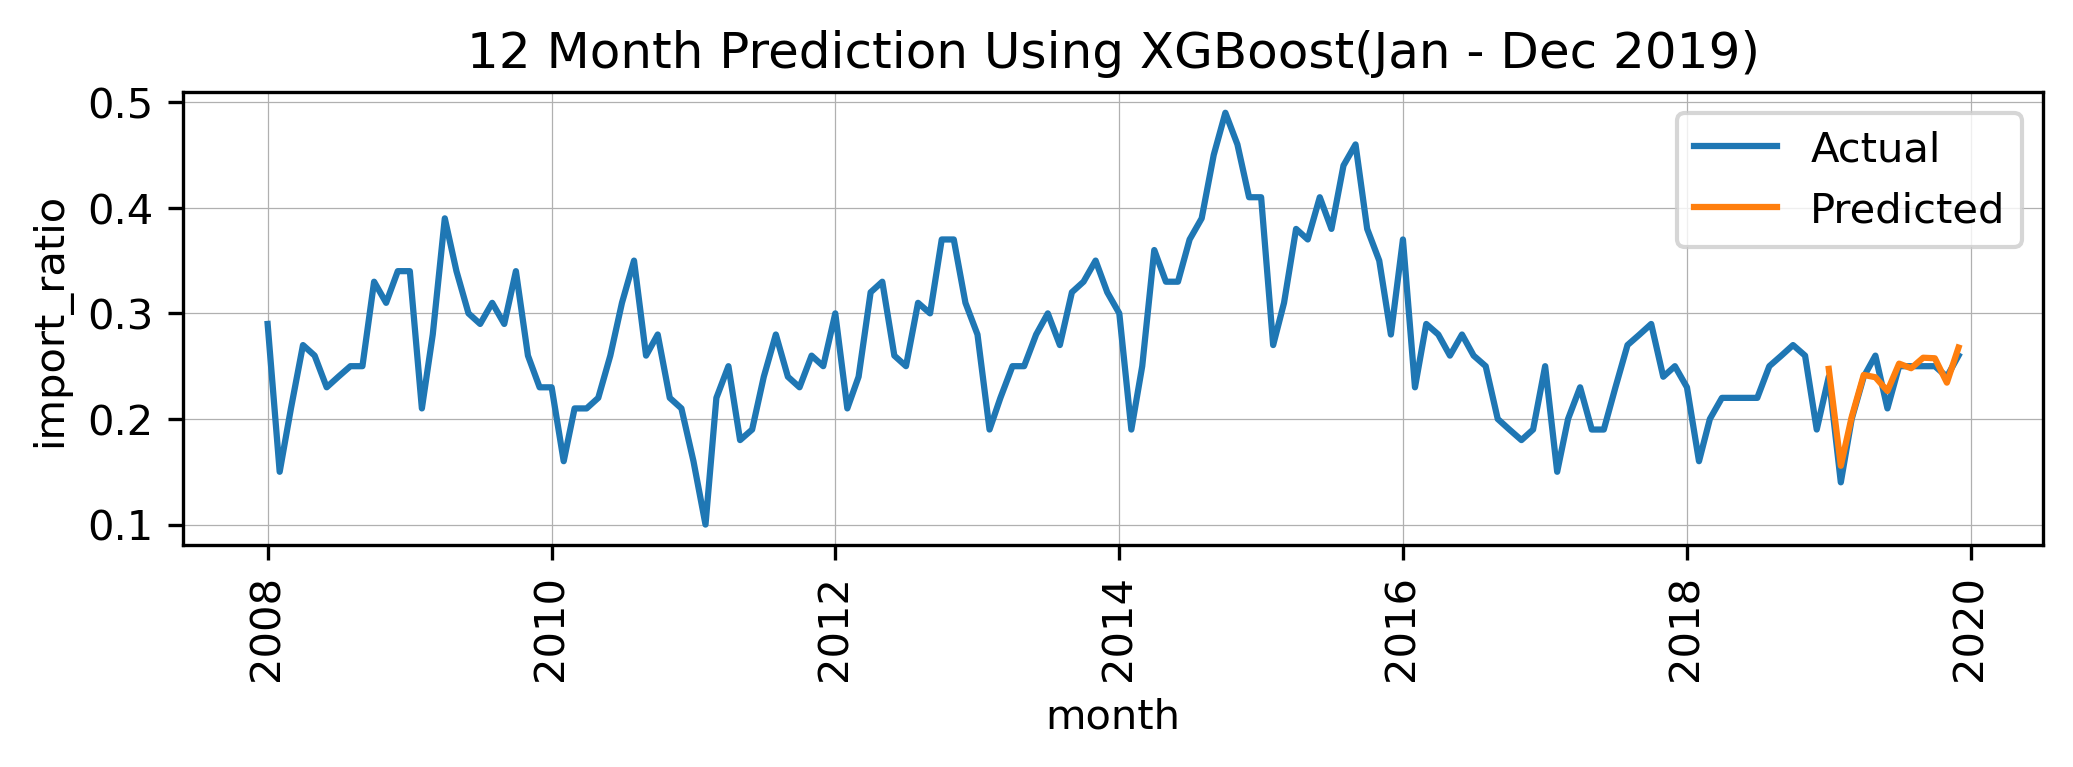

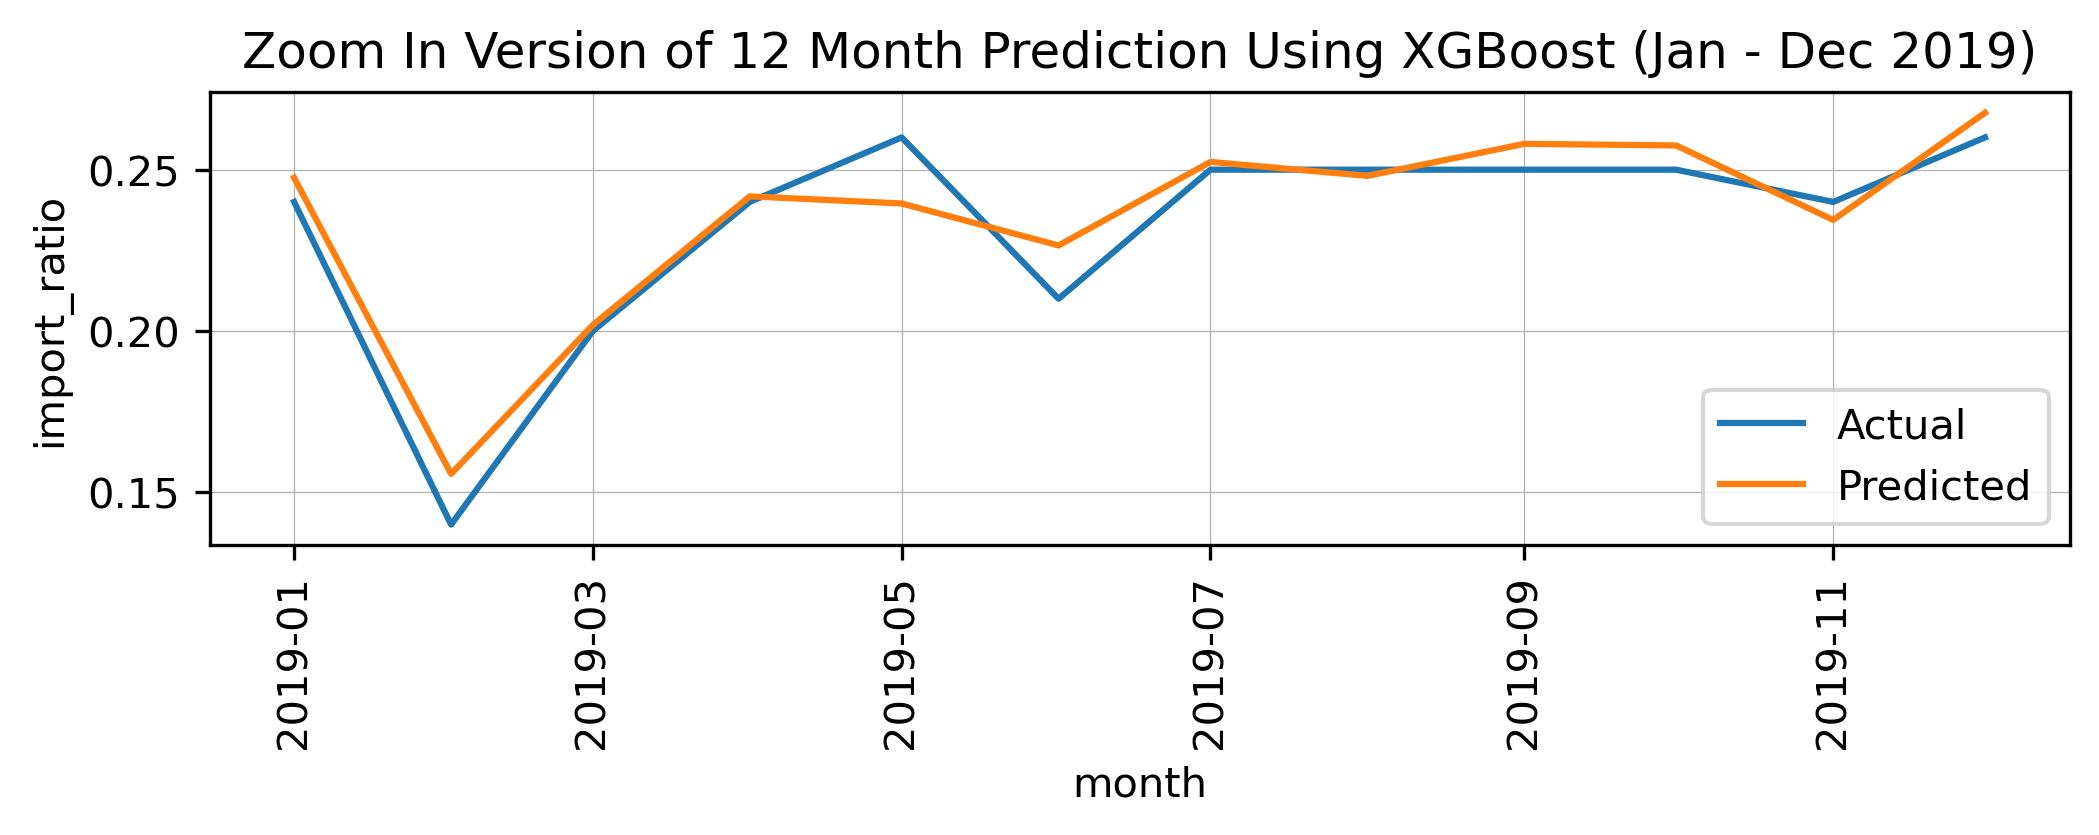

In [22]:
# HAS OUTLIER - all feature
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=combined_data1, x='month', y='import_ratio')
sns.lineplot(data=test_df1, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost(Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_df1, x='month', y='import_ratio')
sns.lineplot(data=test_df1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction Using XGBoost (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)


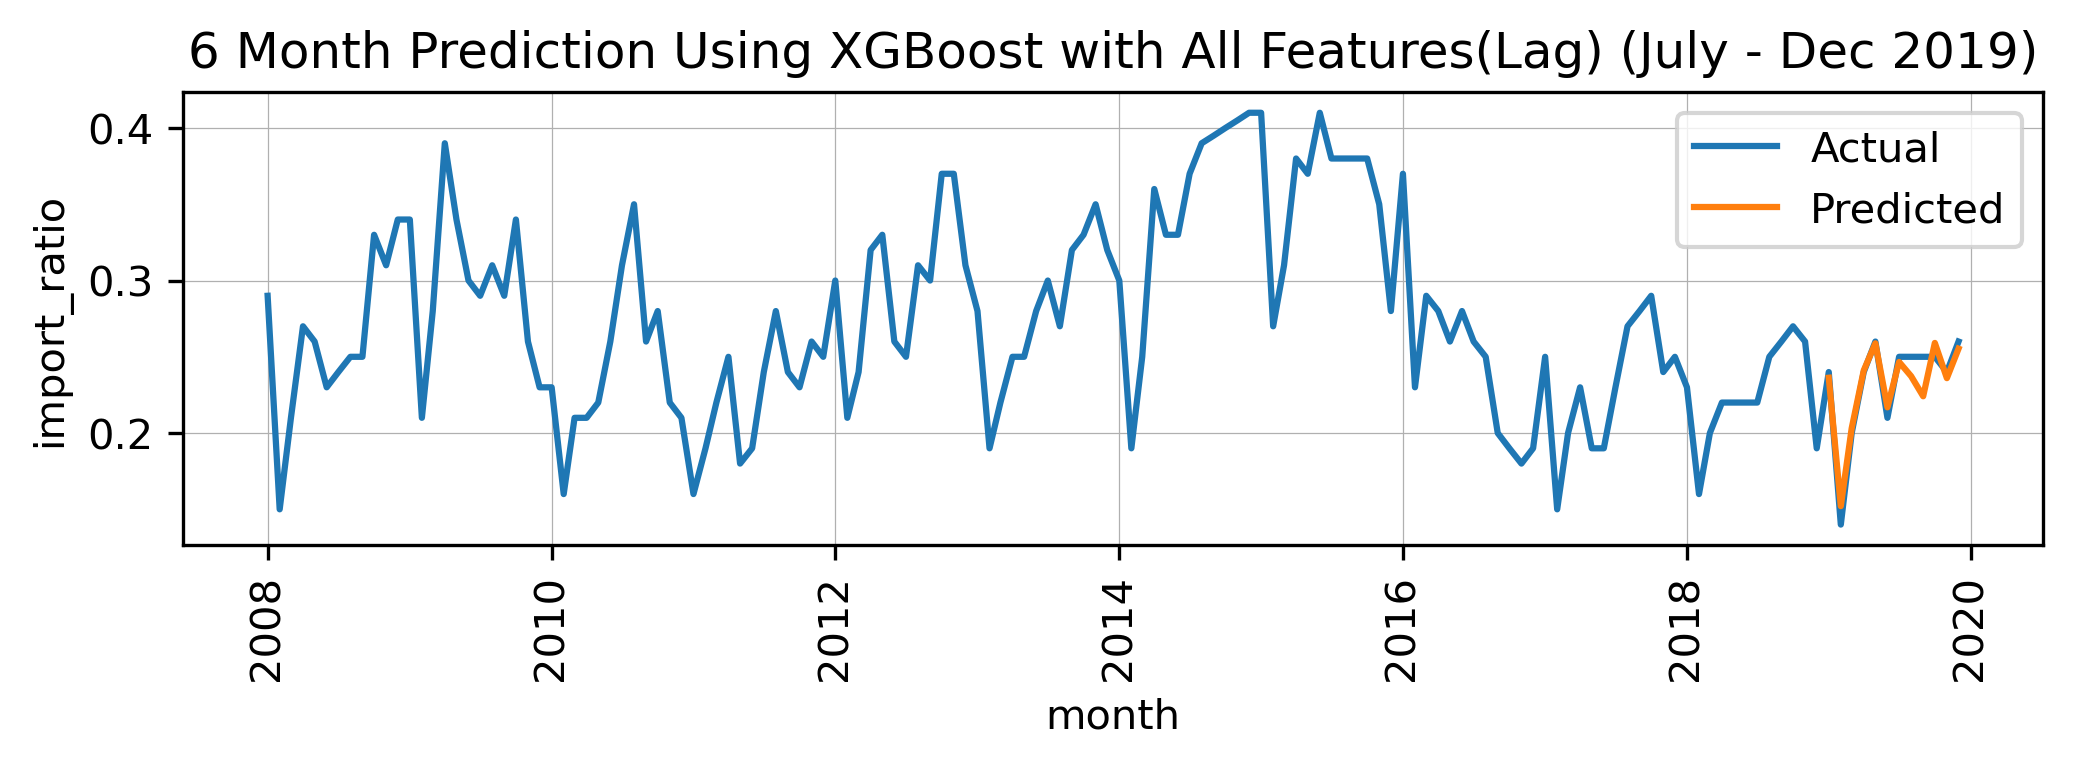

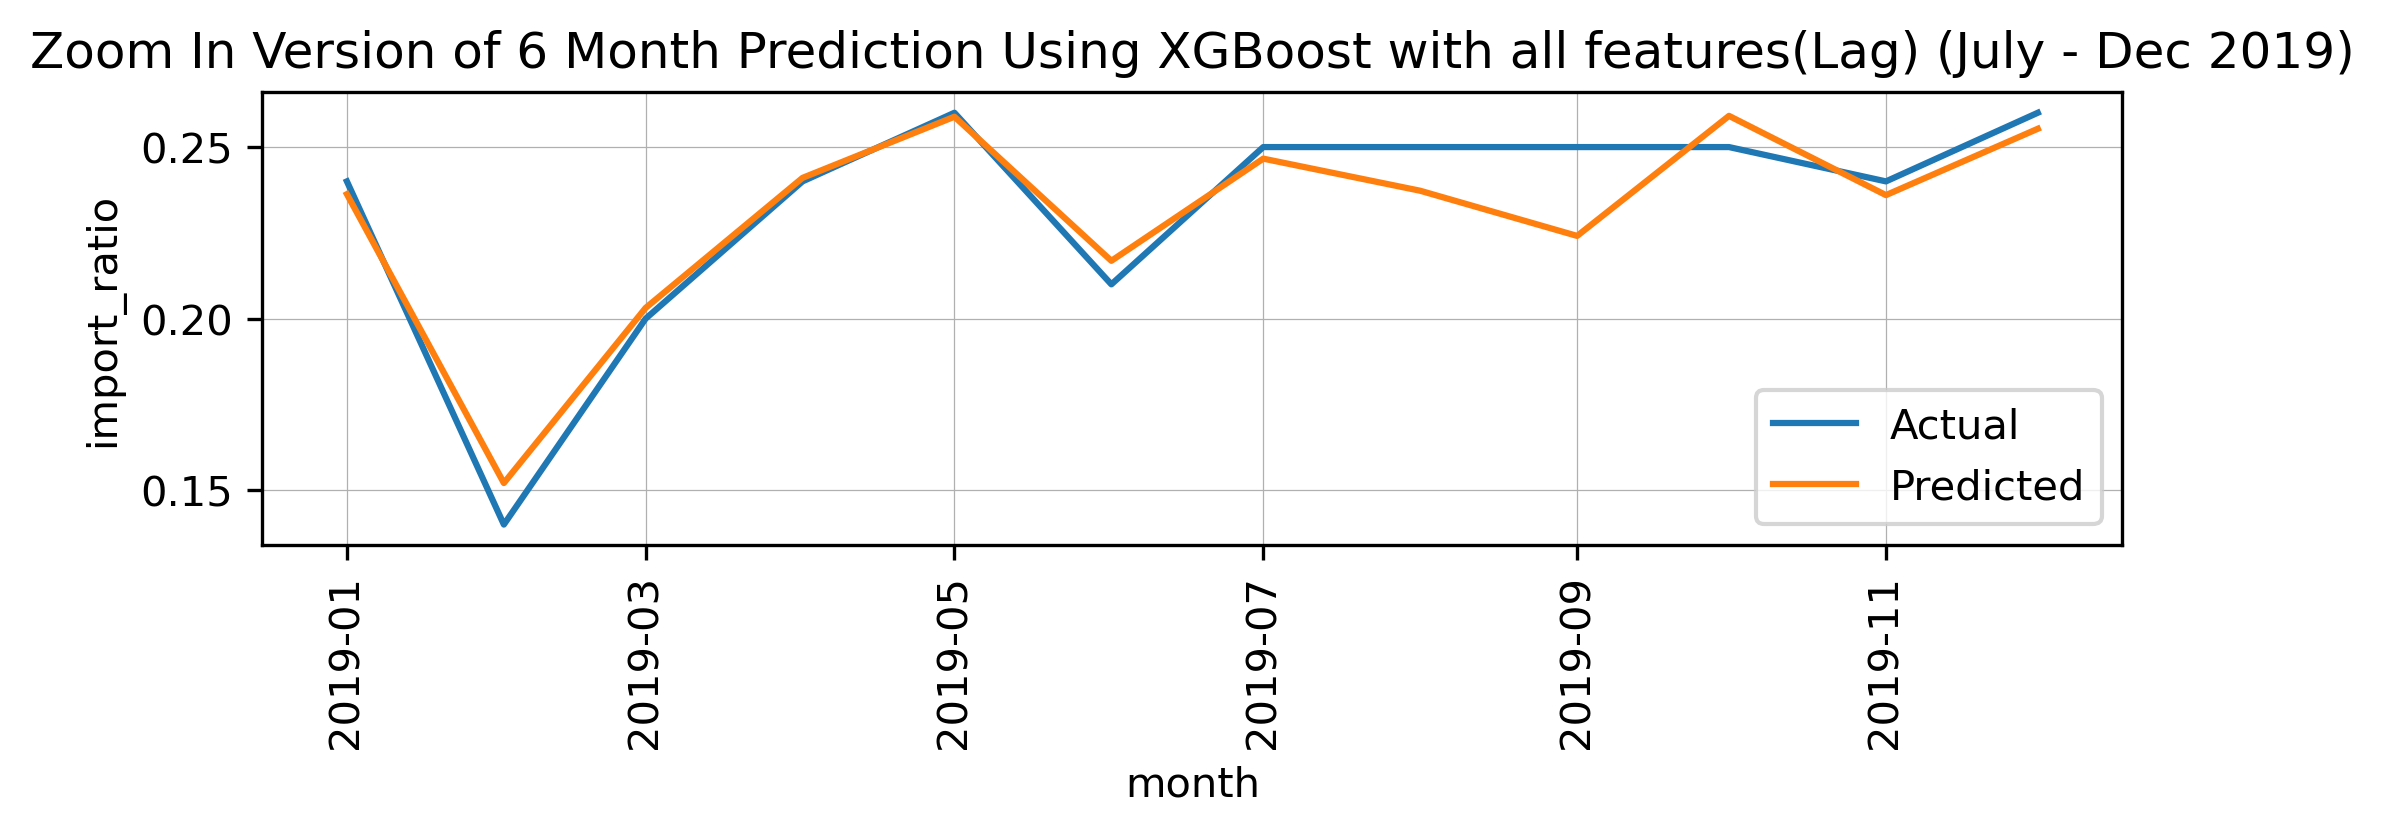

In [86]:
# NO OUTLIER - all feature + LAG
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=month_df_lag, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost with All Features(Lag) (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_no_outlier1_lag, x='month', y='import_ratio')
sns.lineplot(data=test_no_outlier1_lag, x='month', y='predictions').set_title("Zoom In Version of 6 Month Prediction Using XGBoost with all features(Lag) (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [54]:
sel_no_df1 = selected_df_no_outlier1
sel_test_no_df1 = selected_test_no_outlier1

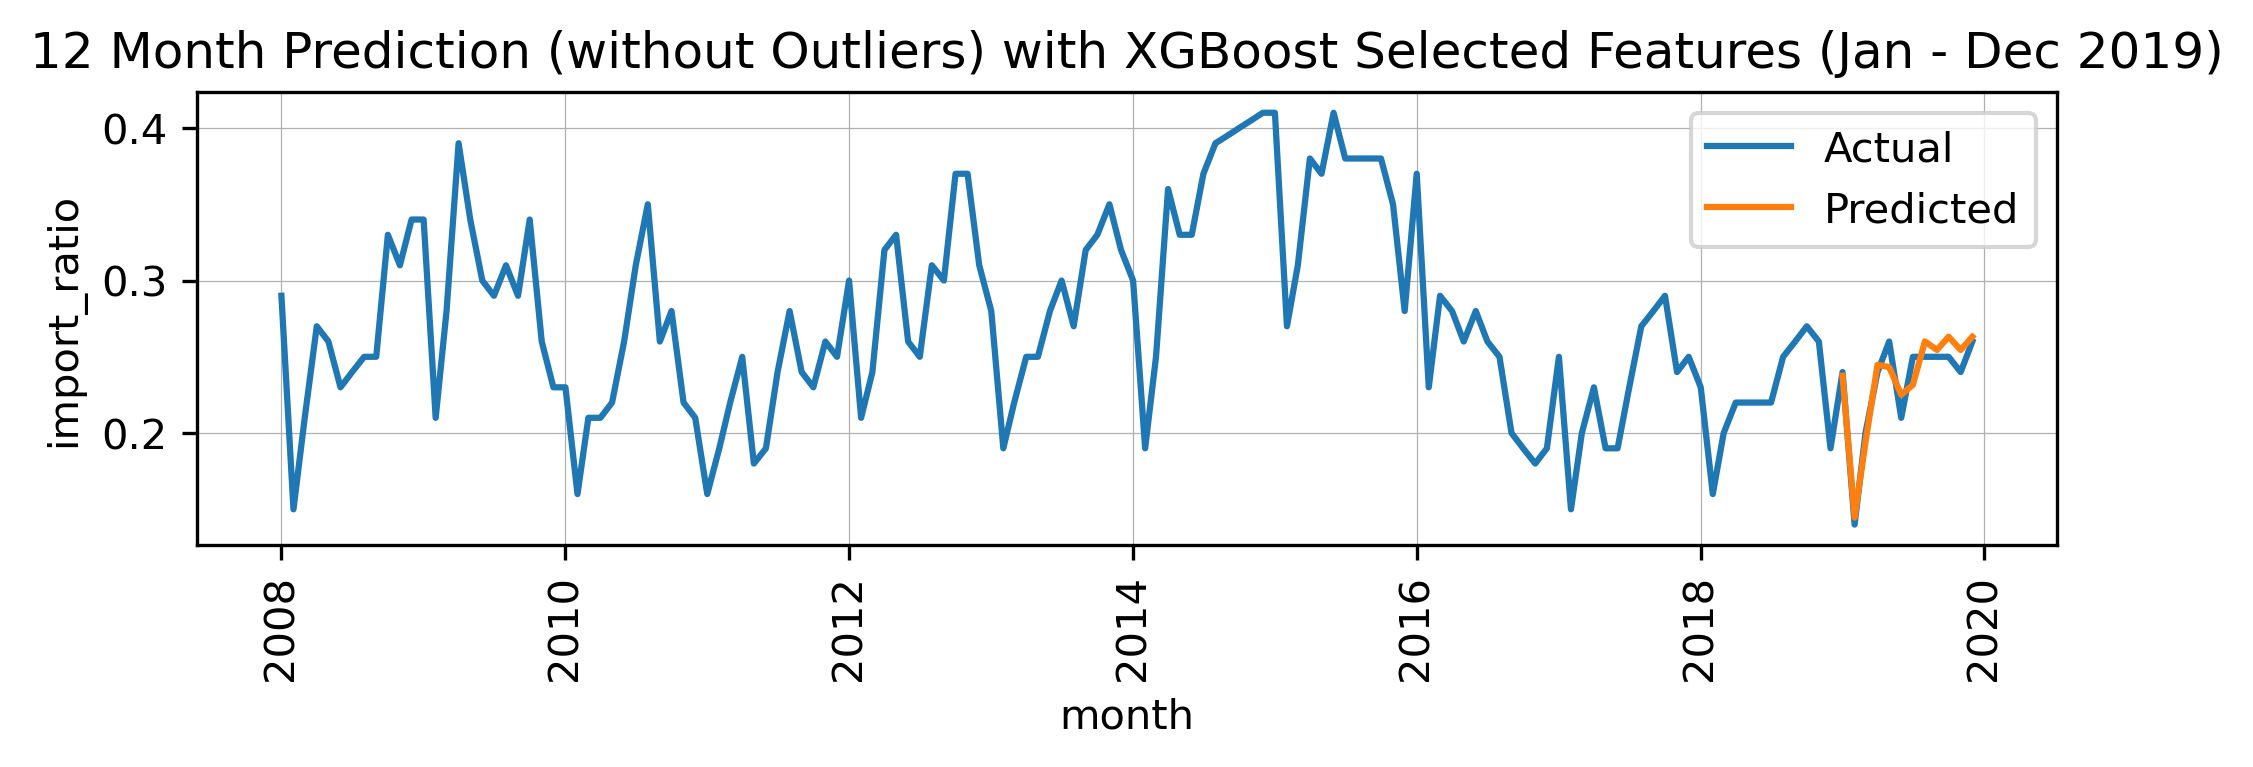

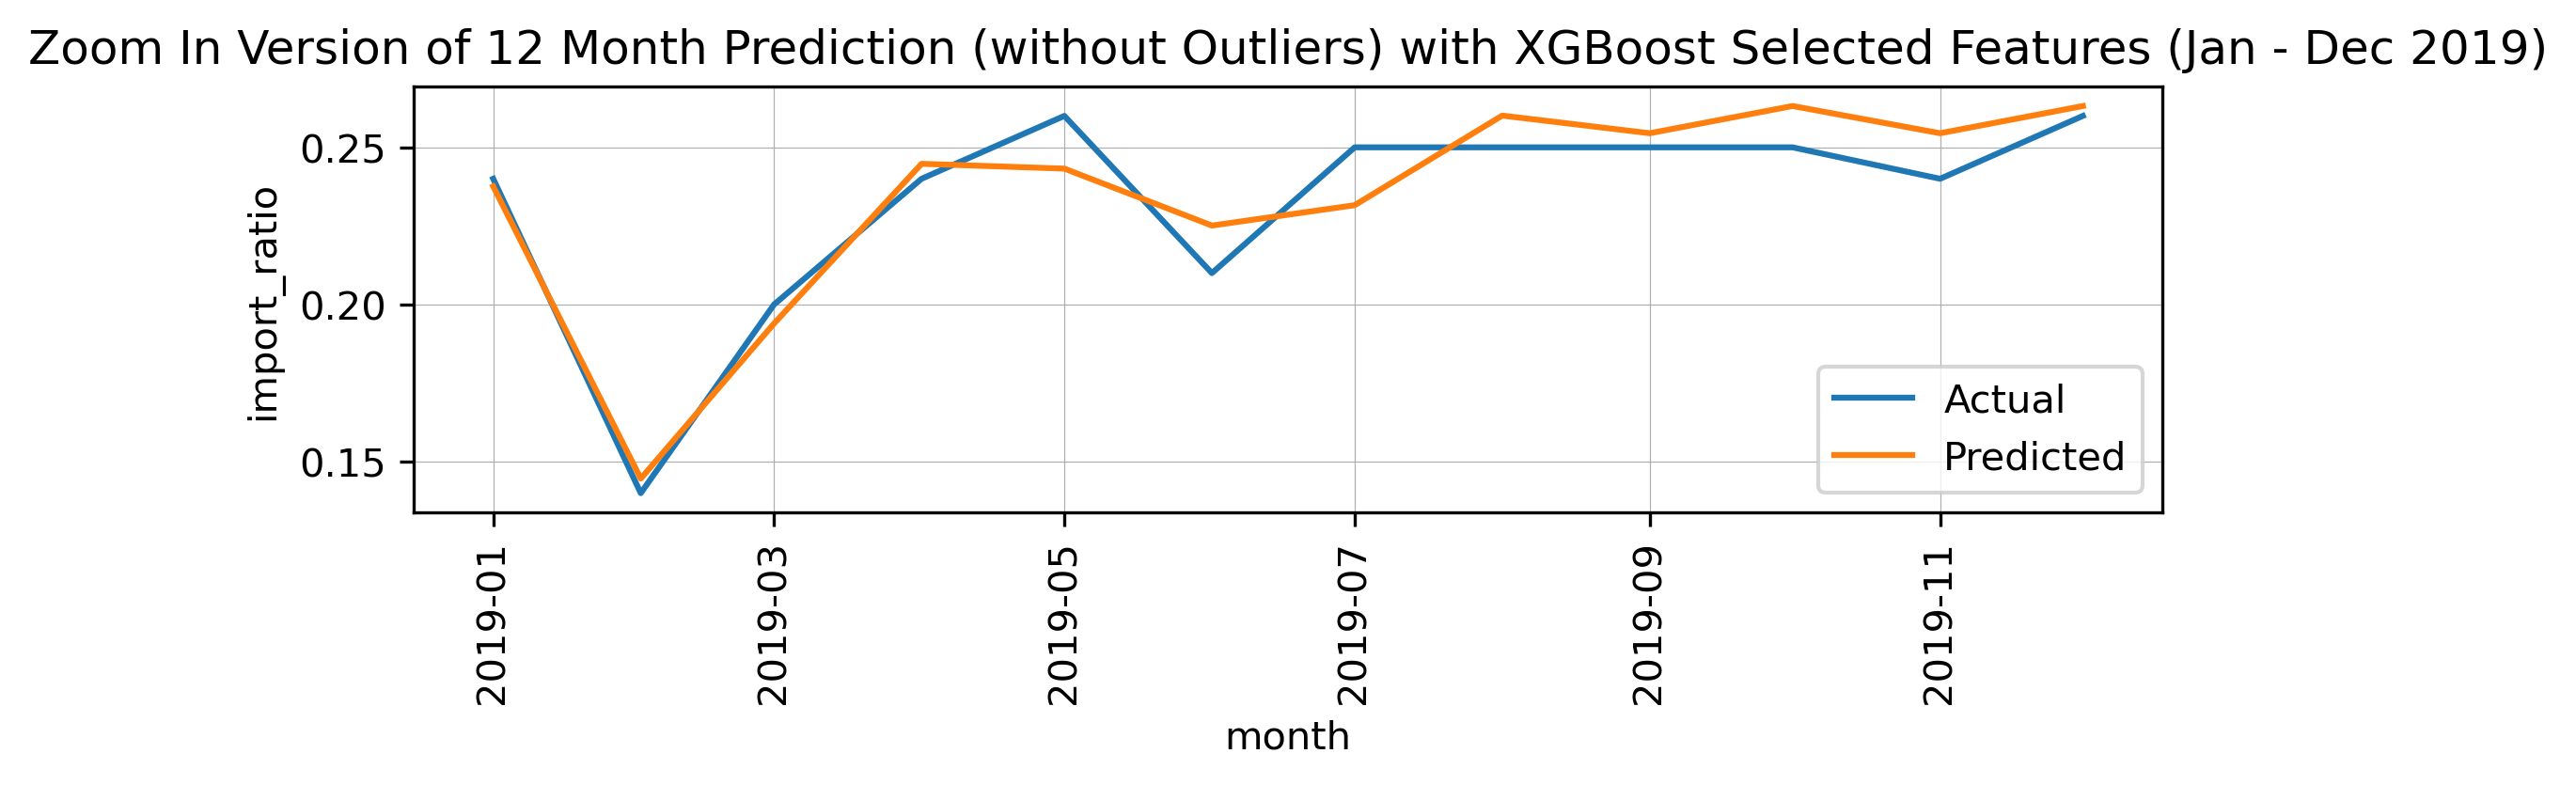

In [87]:
# NO OUTLIER - selected features(11)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=sel_no_df1, x='month', y='import_ratio')
sns.lineplot(data=sel_test_no_df1, x='month', y='predictions').set_title("12 Month Prediction (without Outliers) with XGBoost Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=sel_test_no_df1, x='month', y='import_ratio')
sns.lineplot(data=sel_test_no_df1, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction (without Outliers) with XGBoost Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

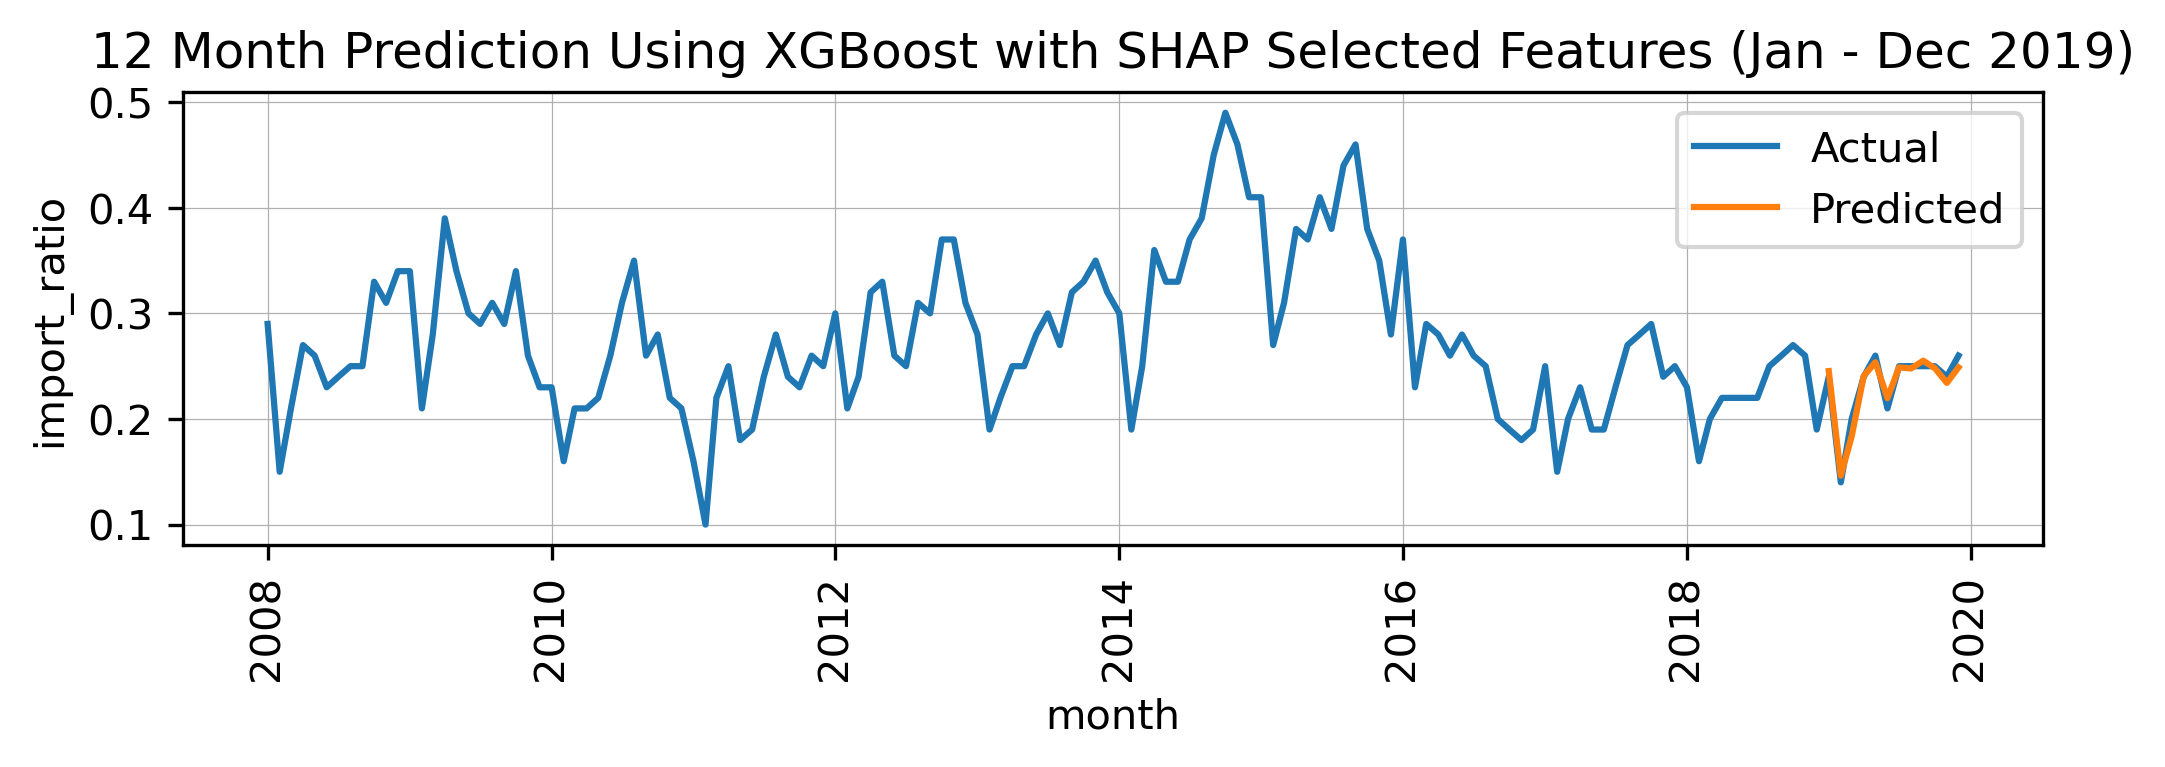

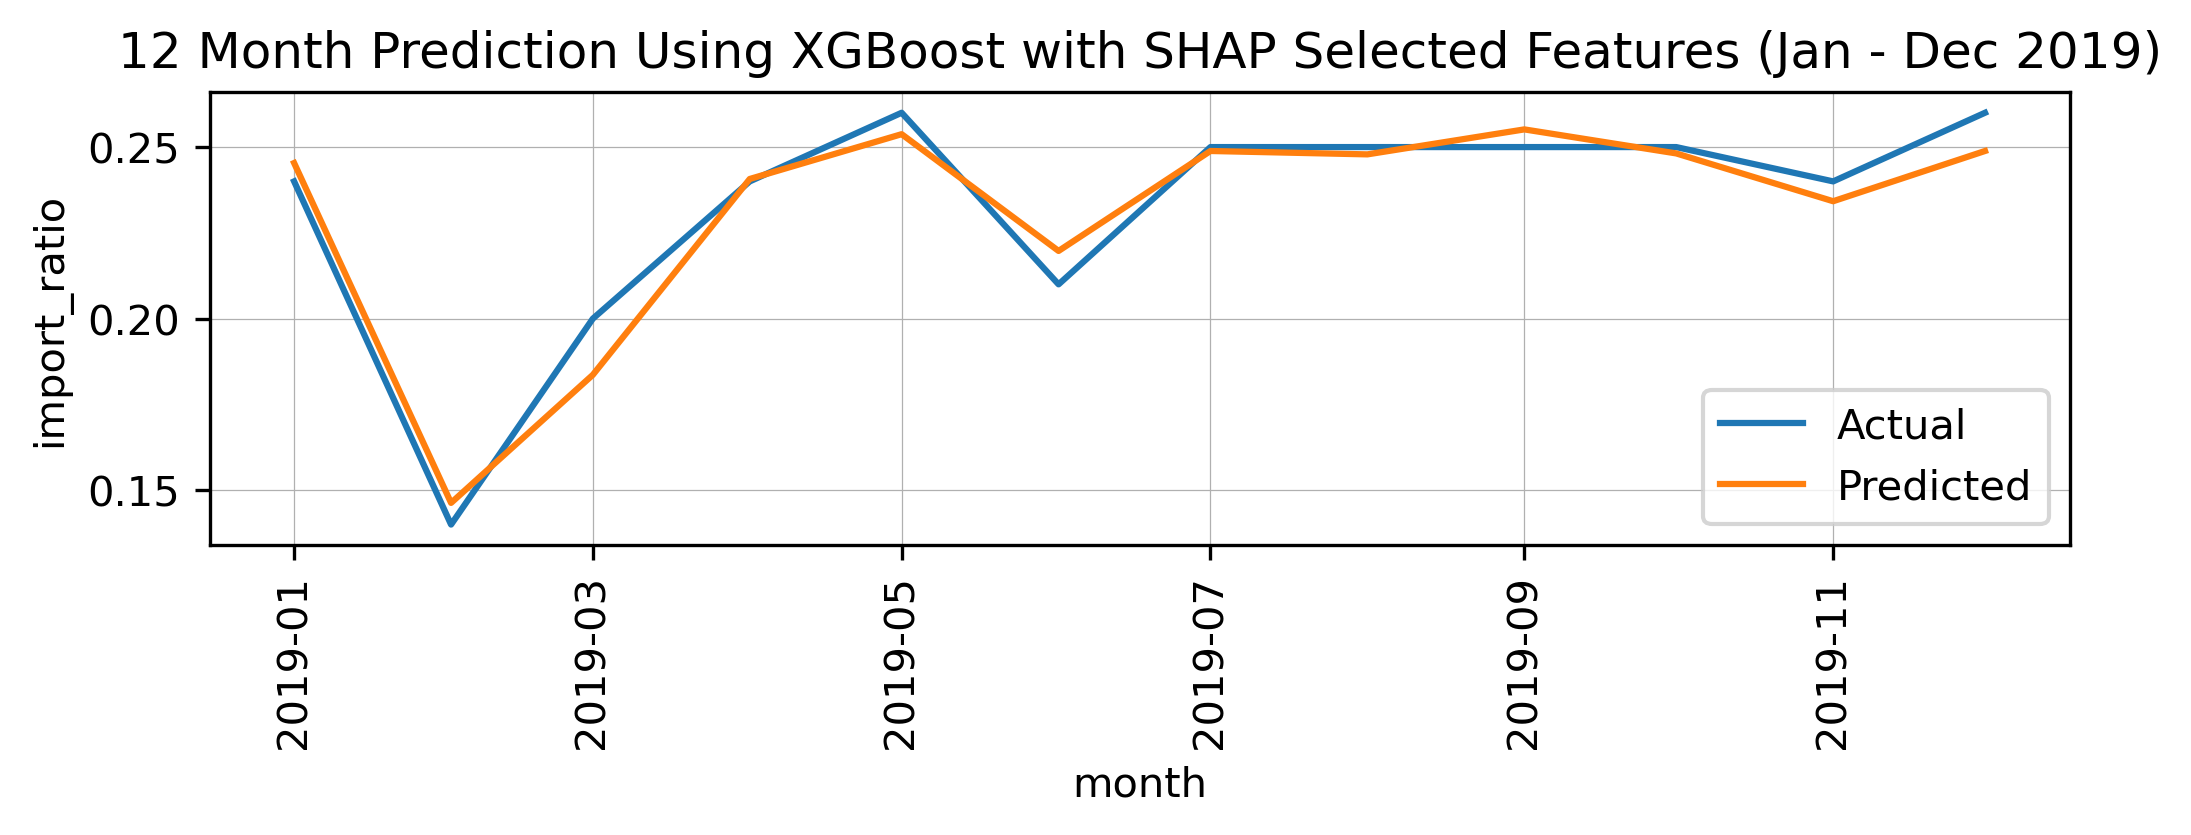

In [43]:
# has OUTLIER - shap selected features(10)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=selected_df1, x='month', y='import_ratio')
sns.lineplot(data=selected_test_df1, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost with SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=selected_test_df1, x='month', y='import_ratio')
sns.lineplot(data=selected_test_df1, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost with SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

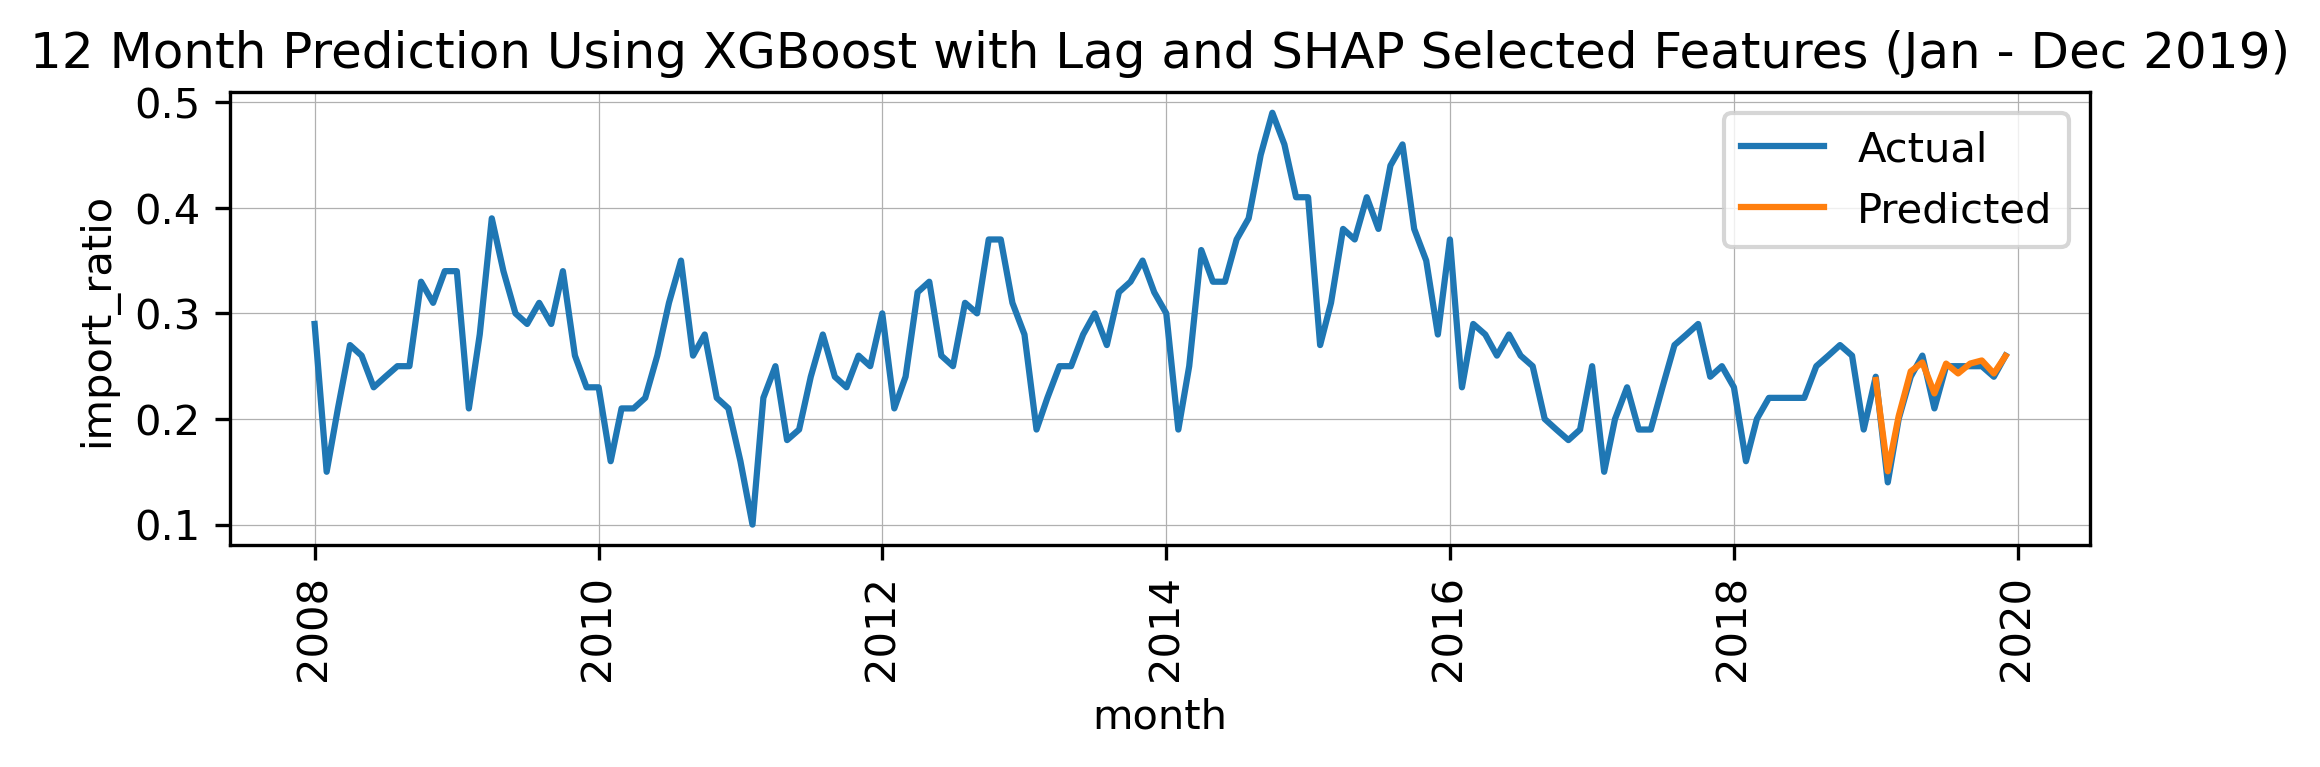

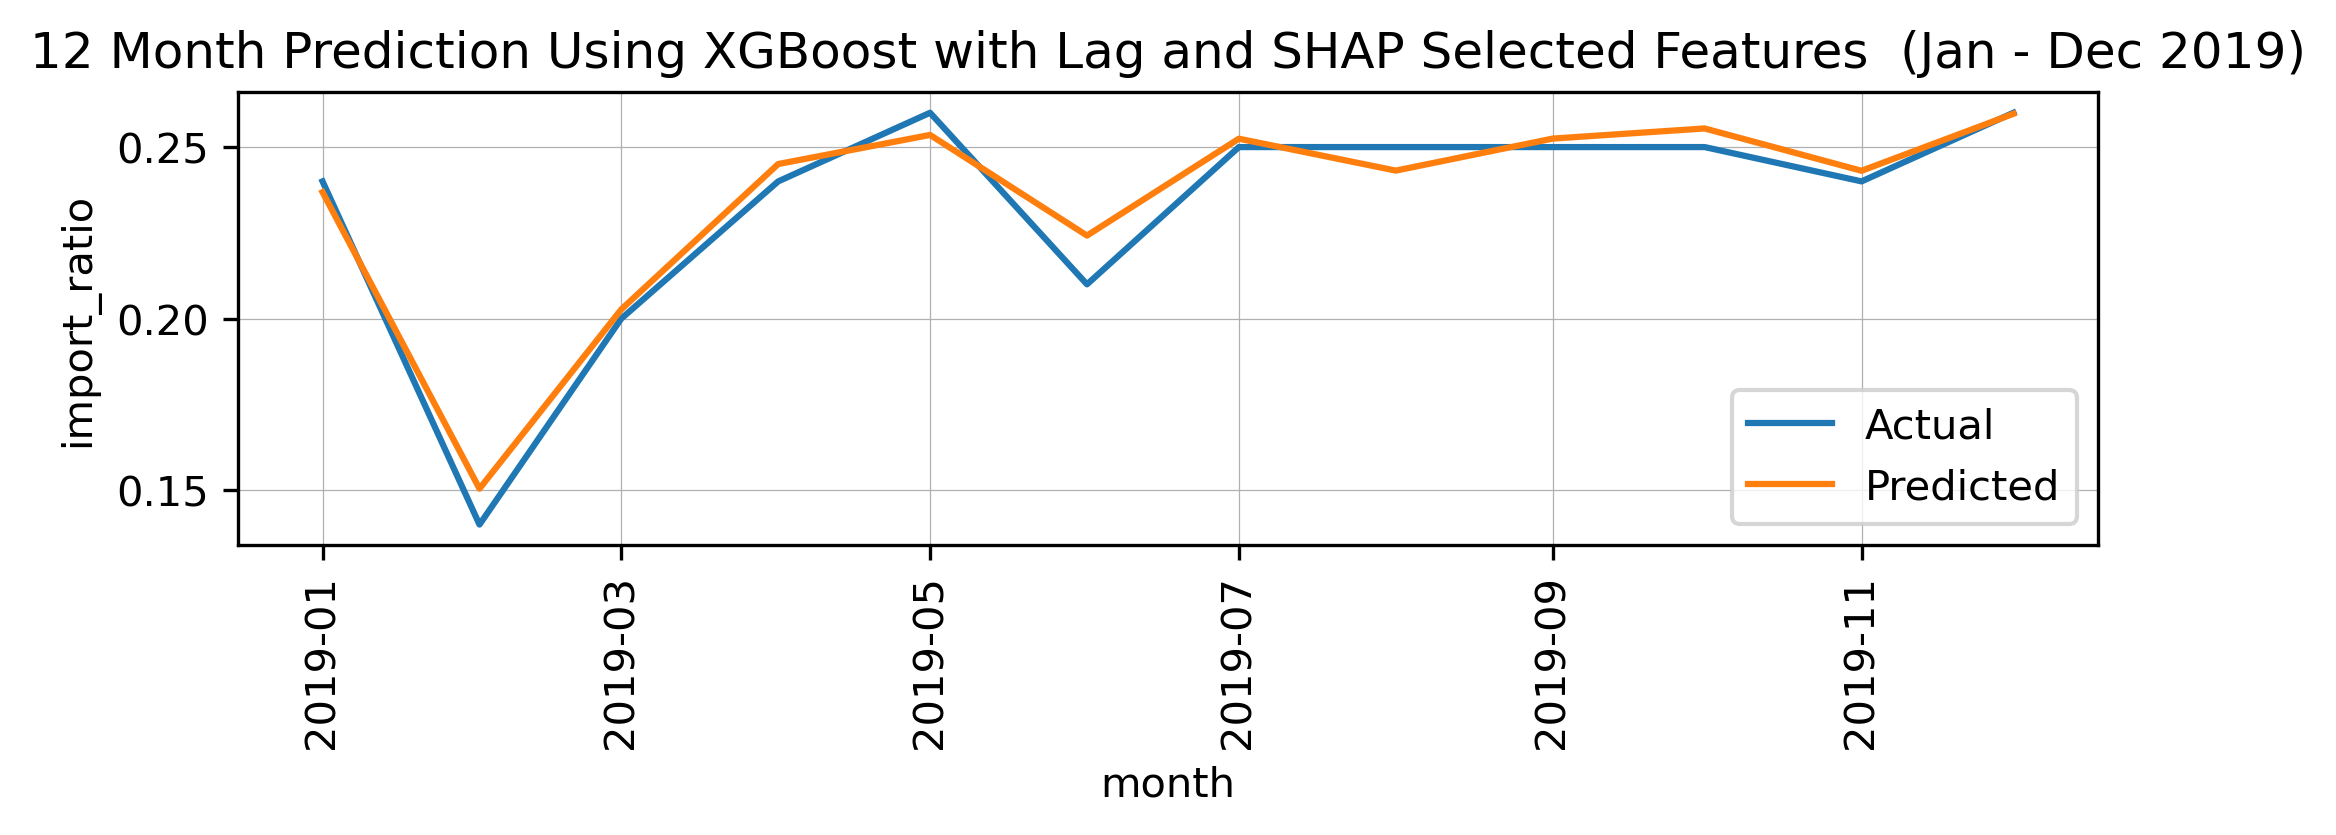

In [44]:
# HAS OUTLIER & Lag feature + shap selected features(10)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost with Lag and SHAP Selected Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost with Lag and SHAP Selected Features  (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

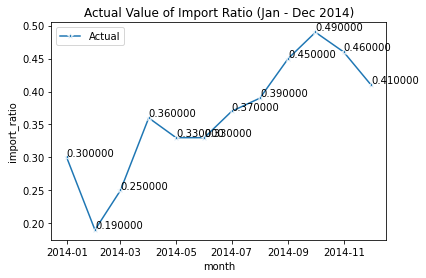

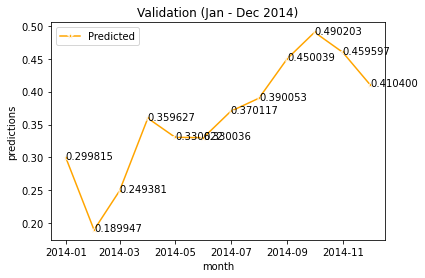

In [23]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + shap selected features(17) & 2014 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Jan - Dec 2014)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.0025, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Jan - Dec 2014)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0025, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

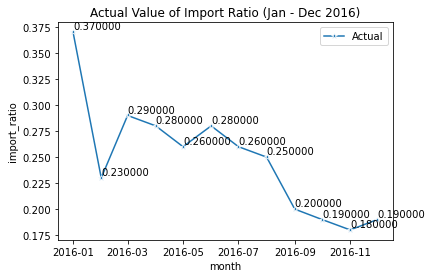

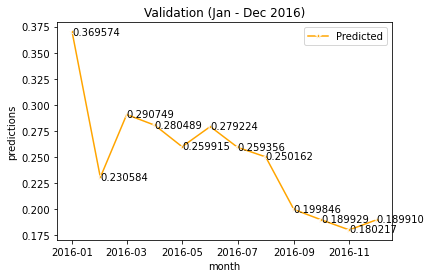

In [26]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + shap selected features(17) & 2016 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Jan - Dec 2016)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.0025, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Jan - Dec 2016)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0025, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

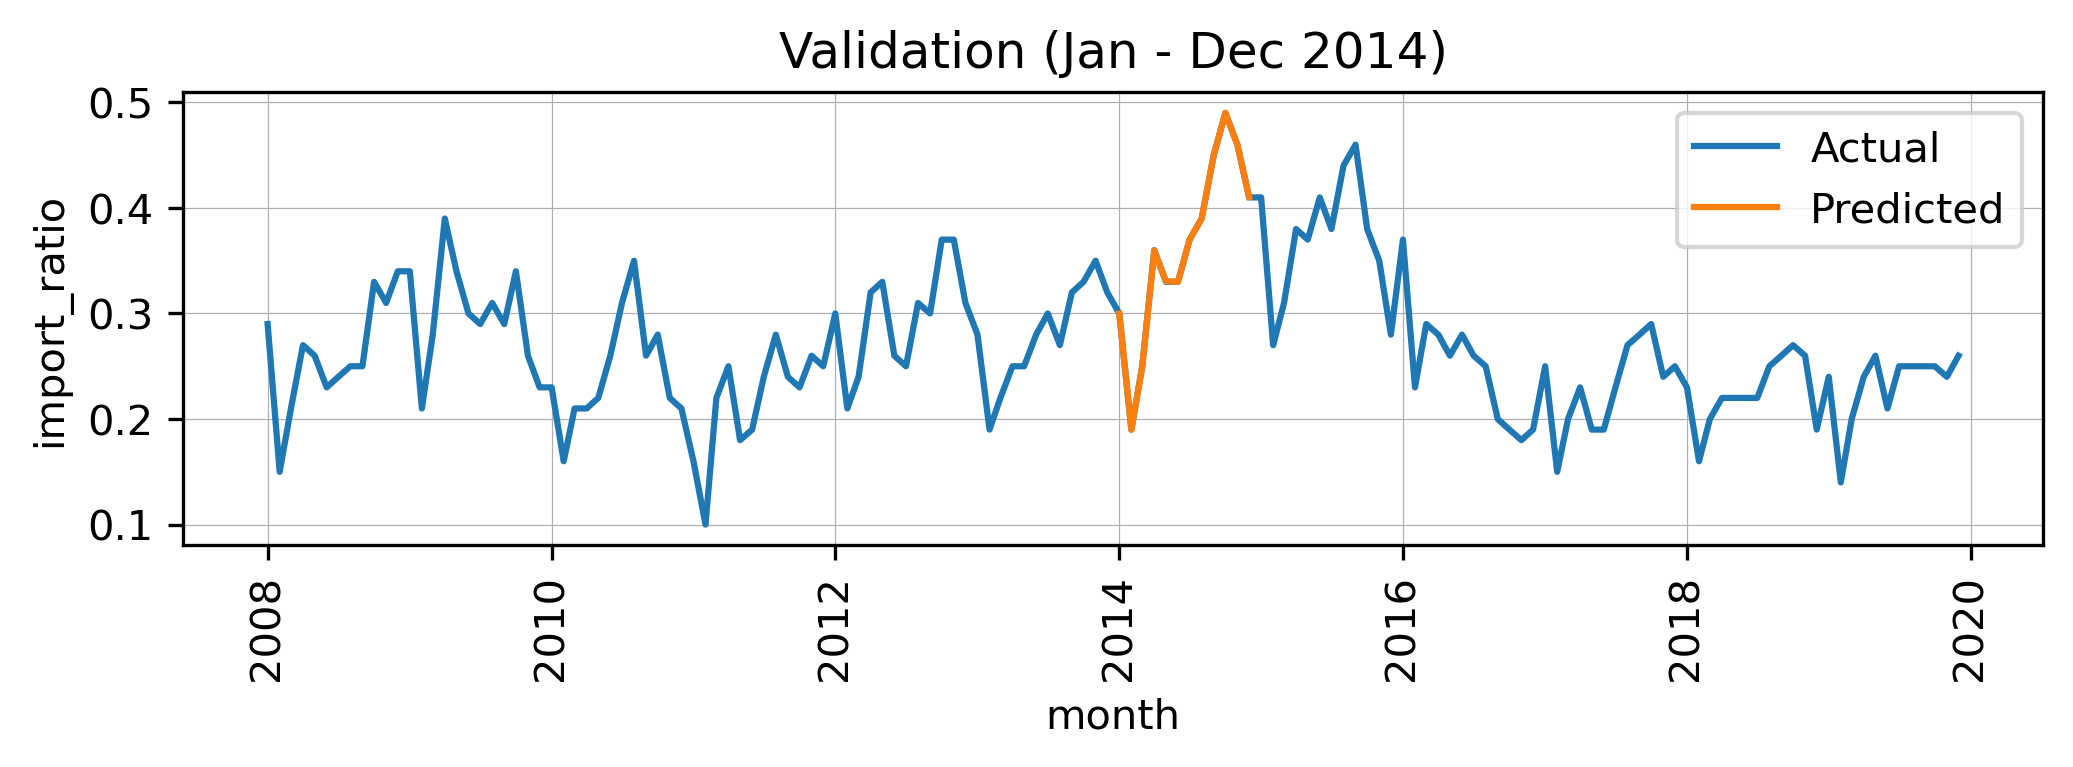

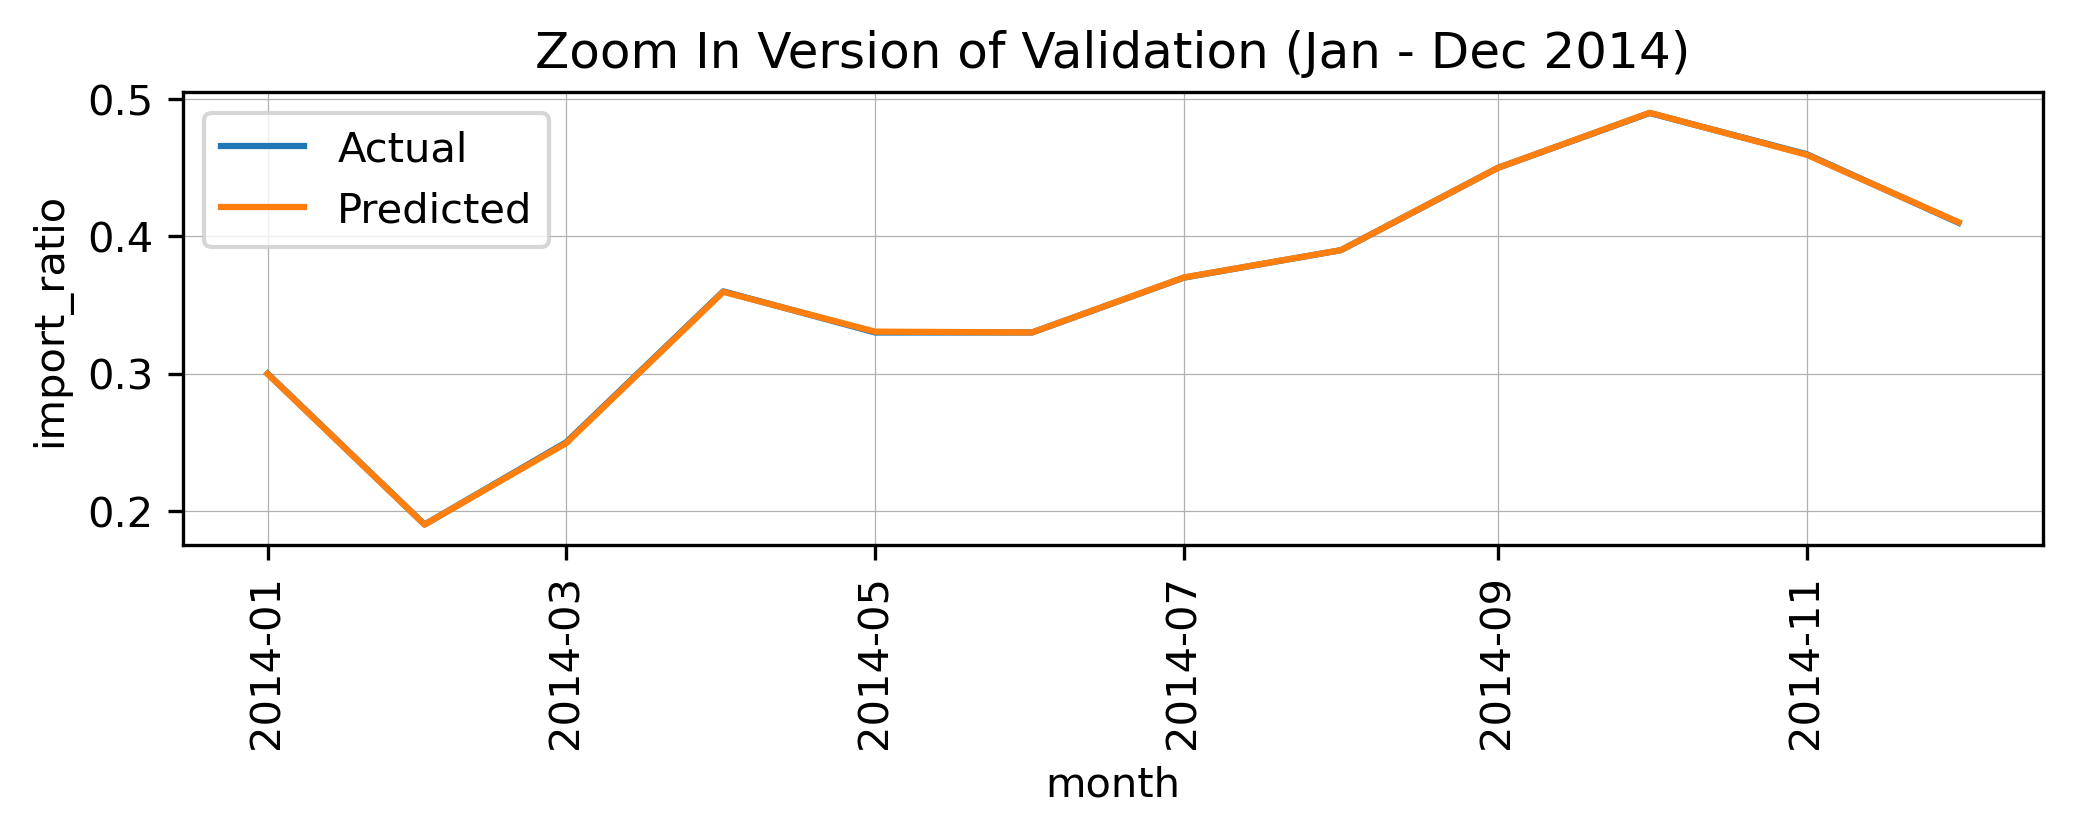

In [86]:
# HAS OUTLIER & Lag feature + shap selected features(10) & 2014 validation
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Validation (Jan - Dec 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=val_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Zoom In Version of Validation (Jan - Dec 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

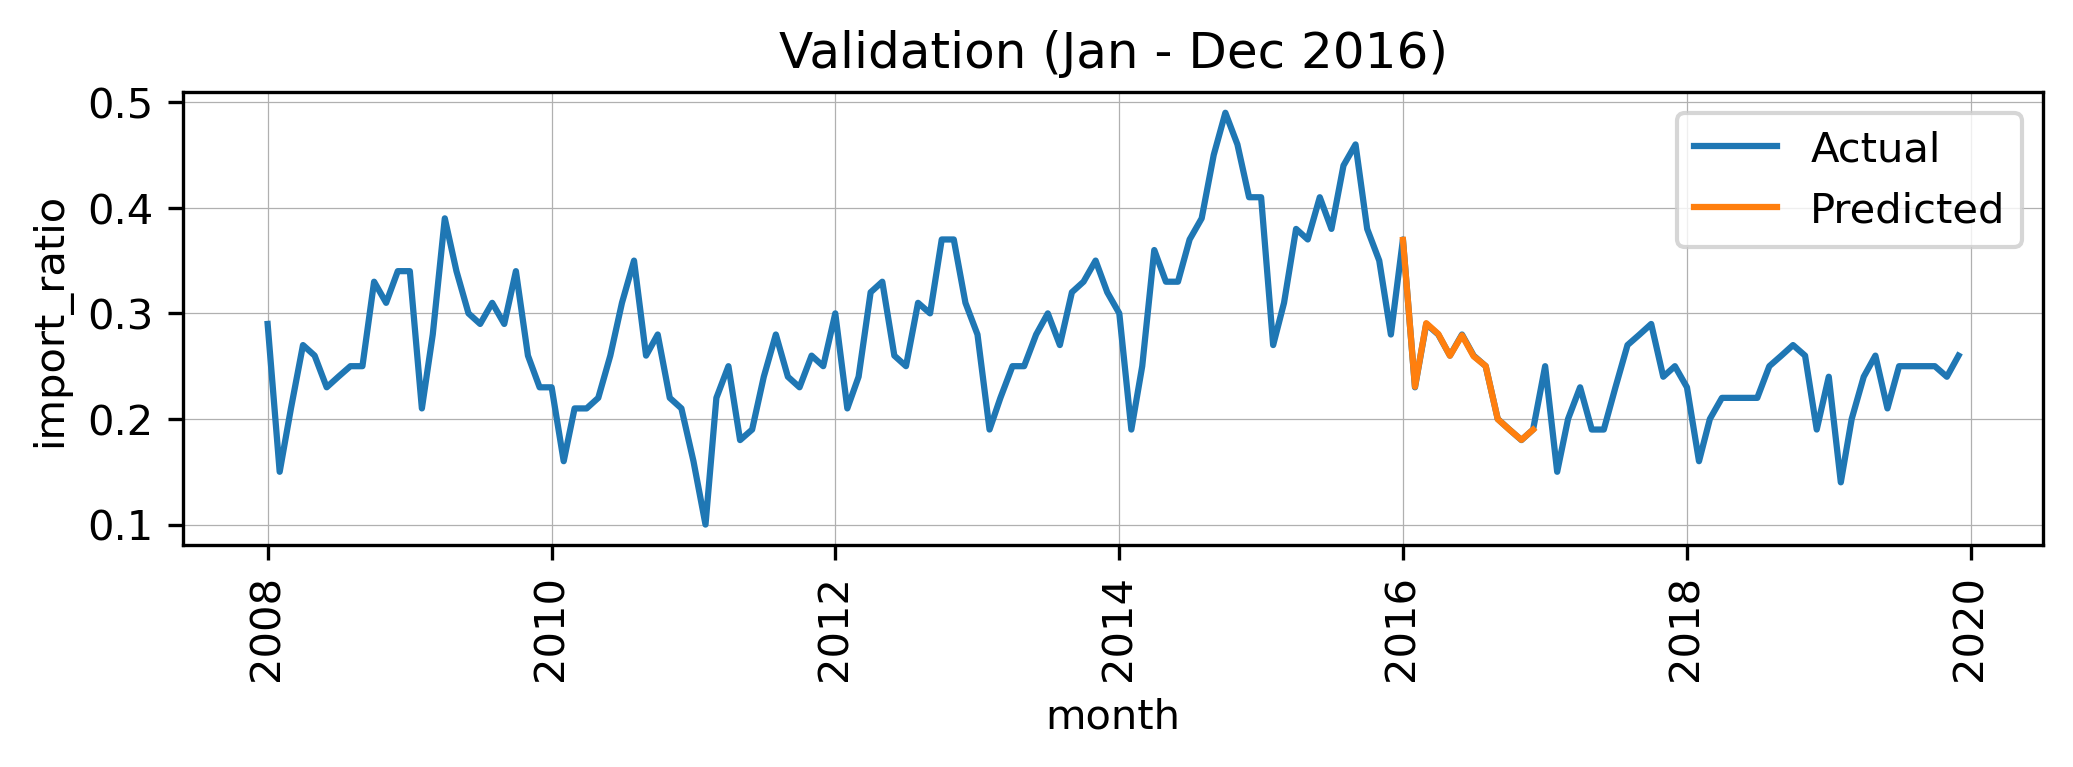

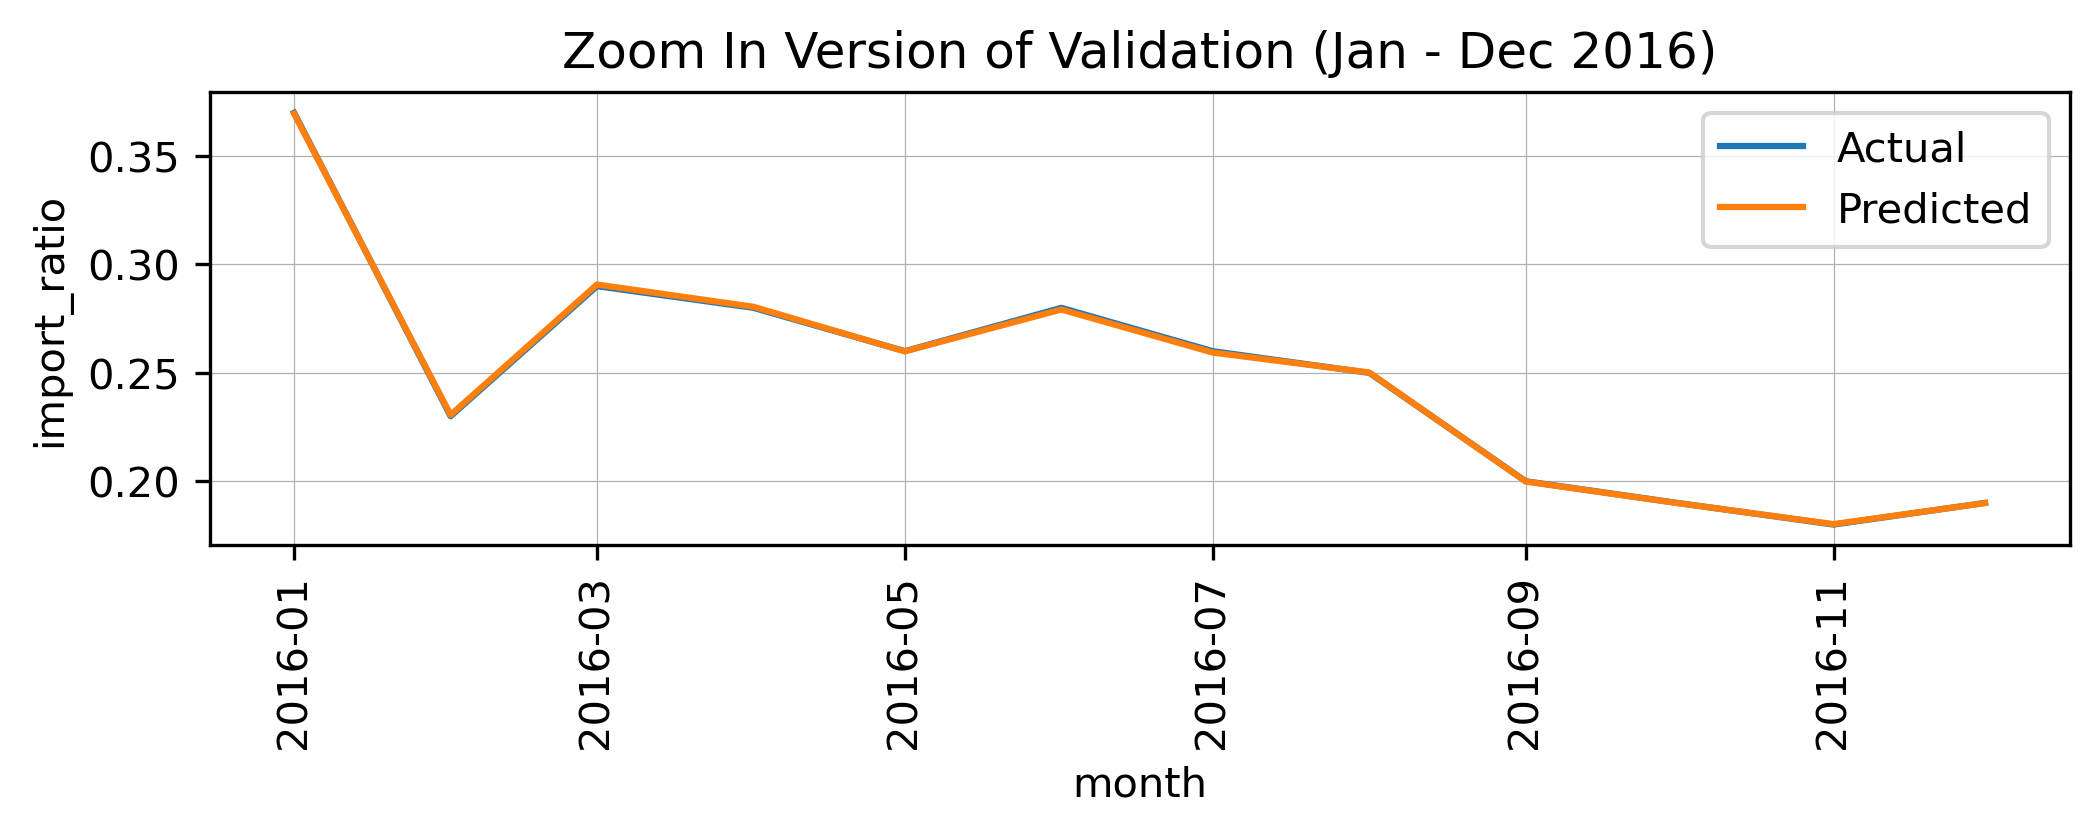

In [48]:
# HAS OUTLIER & Lag feature + shap selected features(10) & 2016 validation
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Validation (Jan - Dec 2016)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=val_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Zoom In Version of Validation (Jan - Dec 2016)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Model Output Explaination Using Shap

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot which can be found under the waterfall plot.

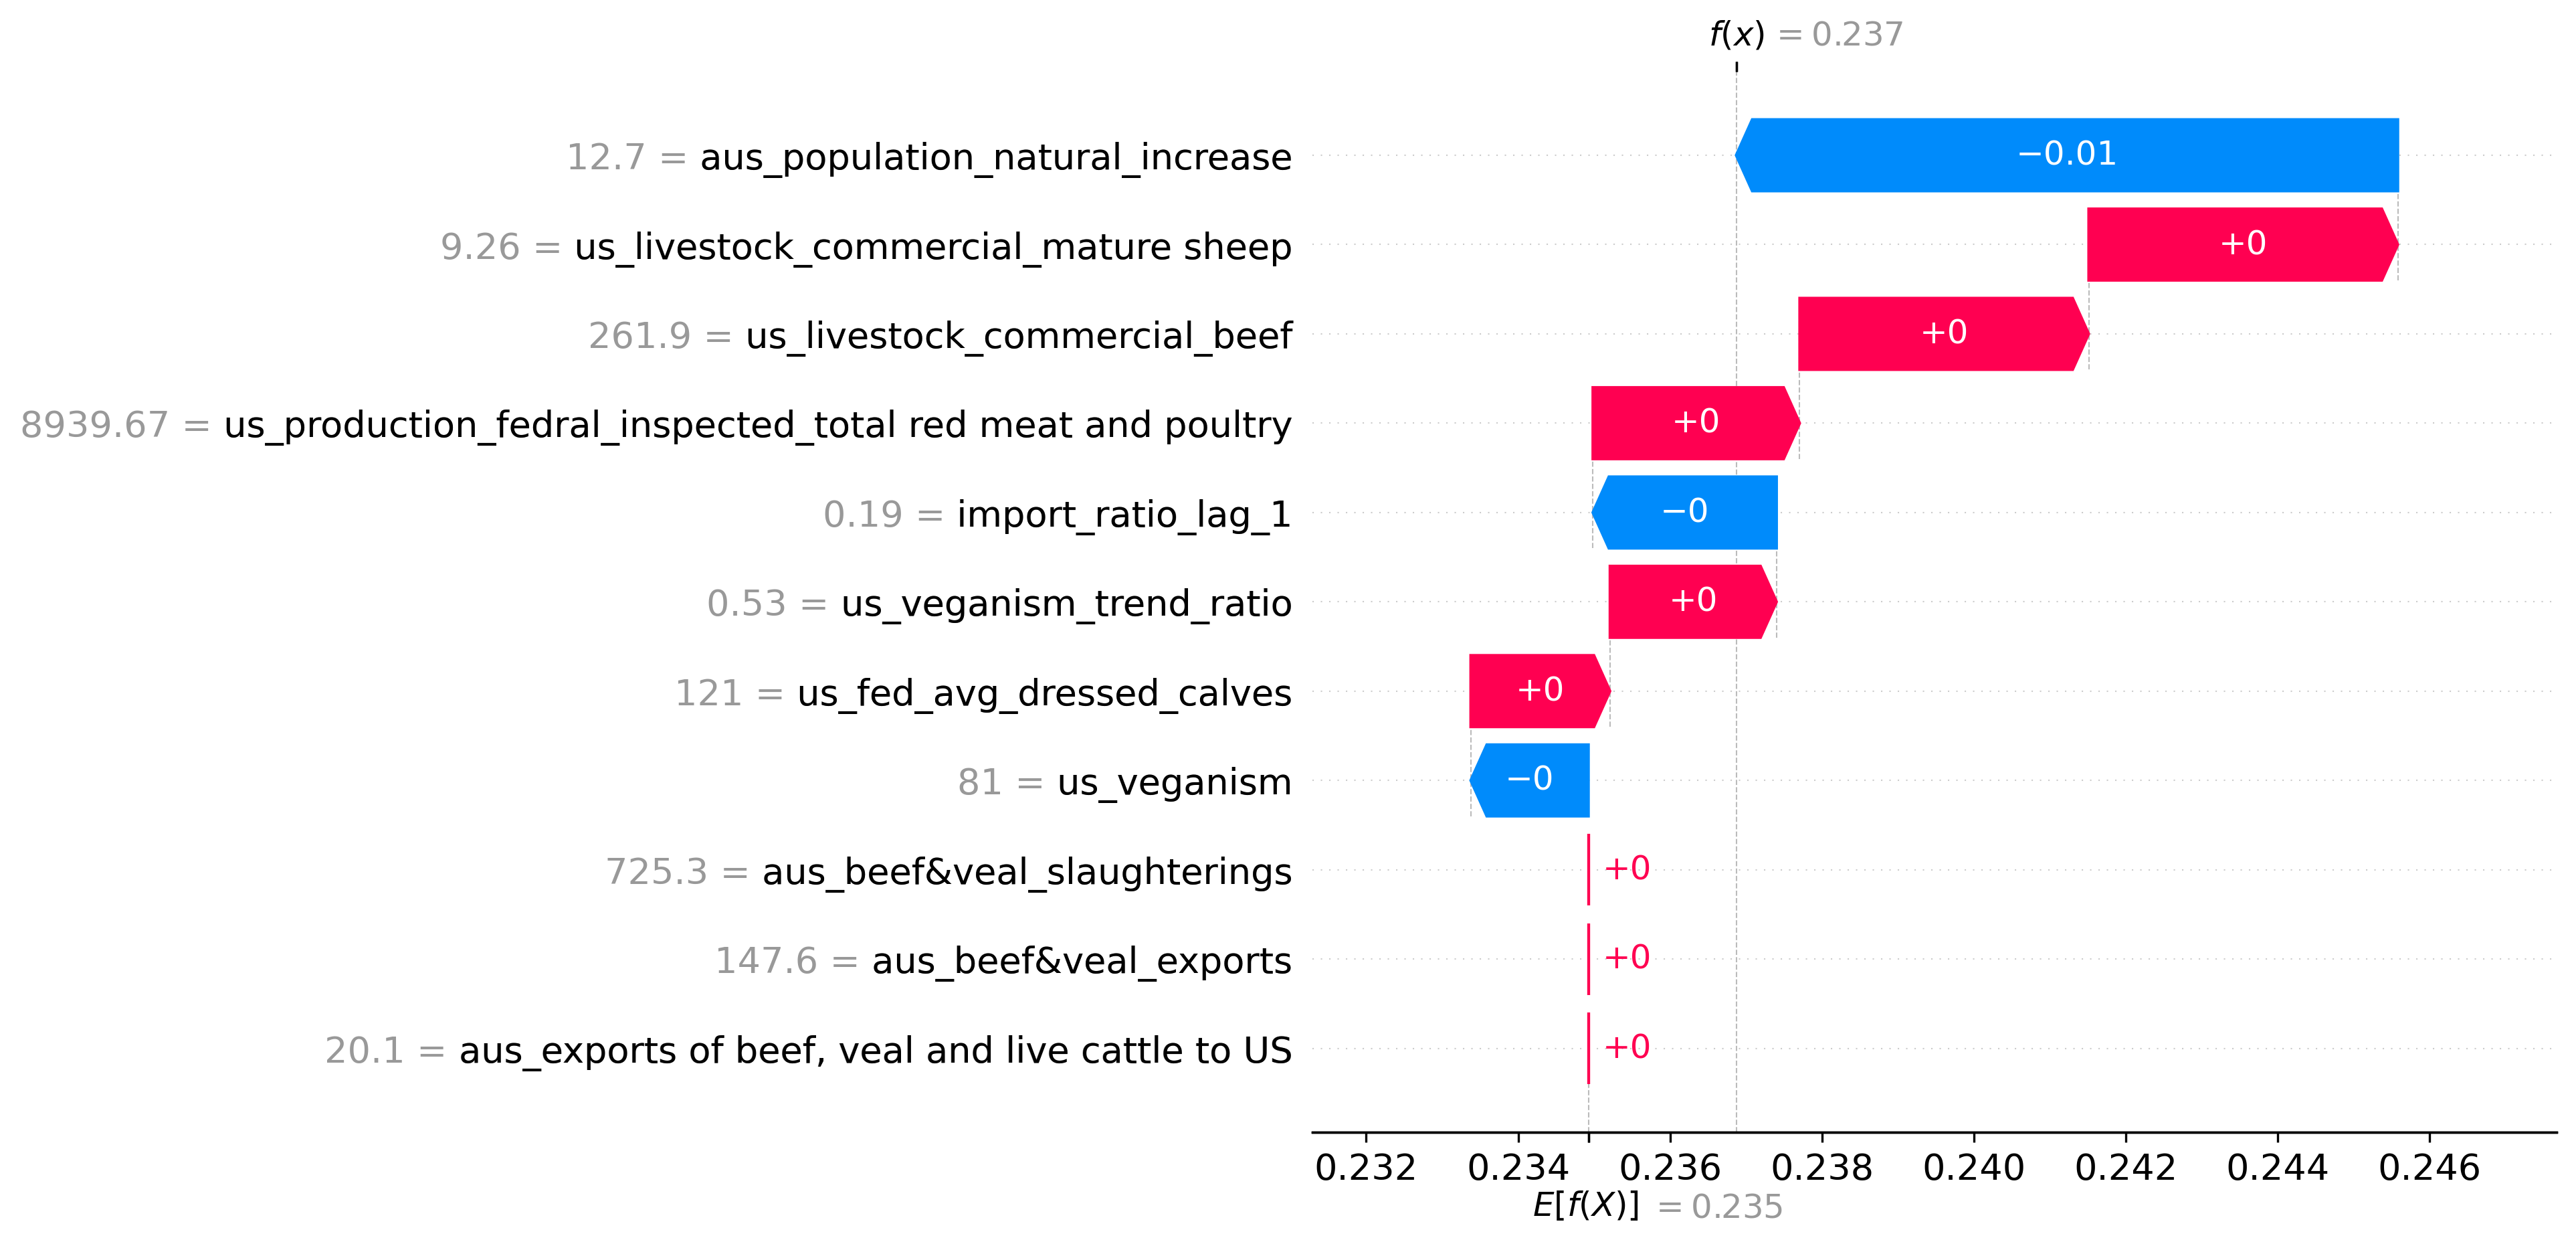

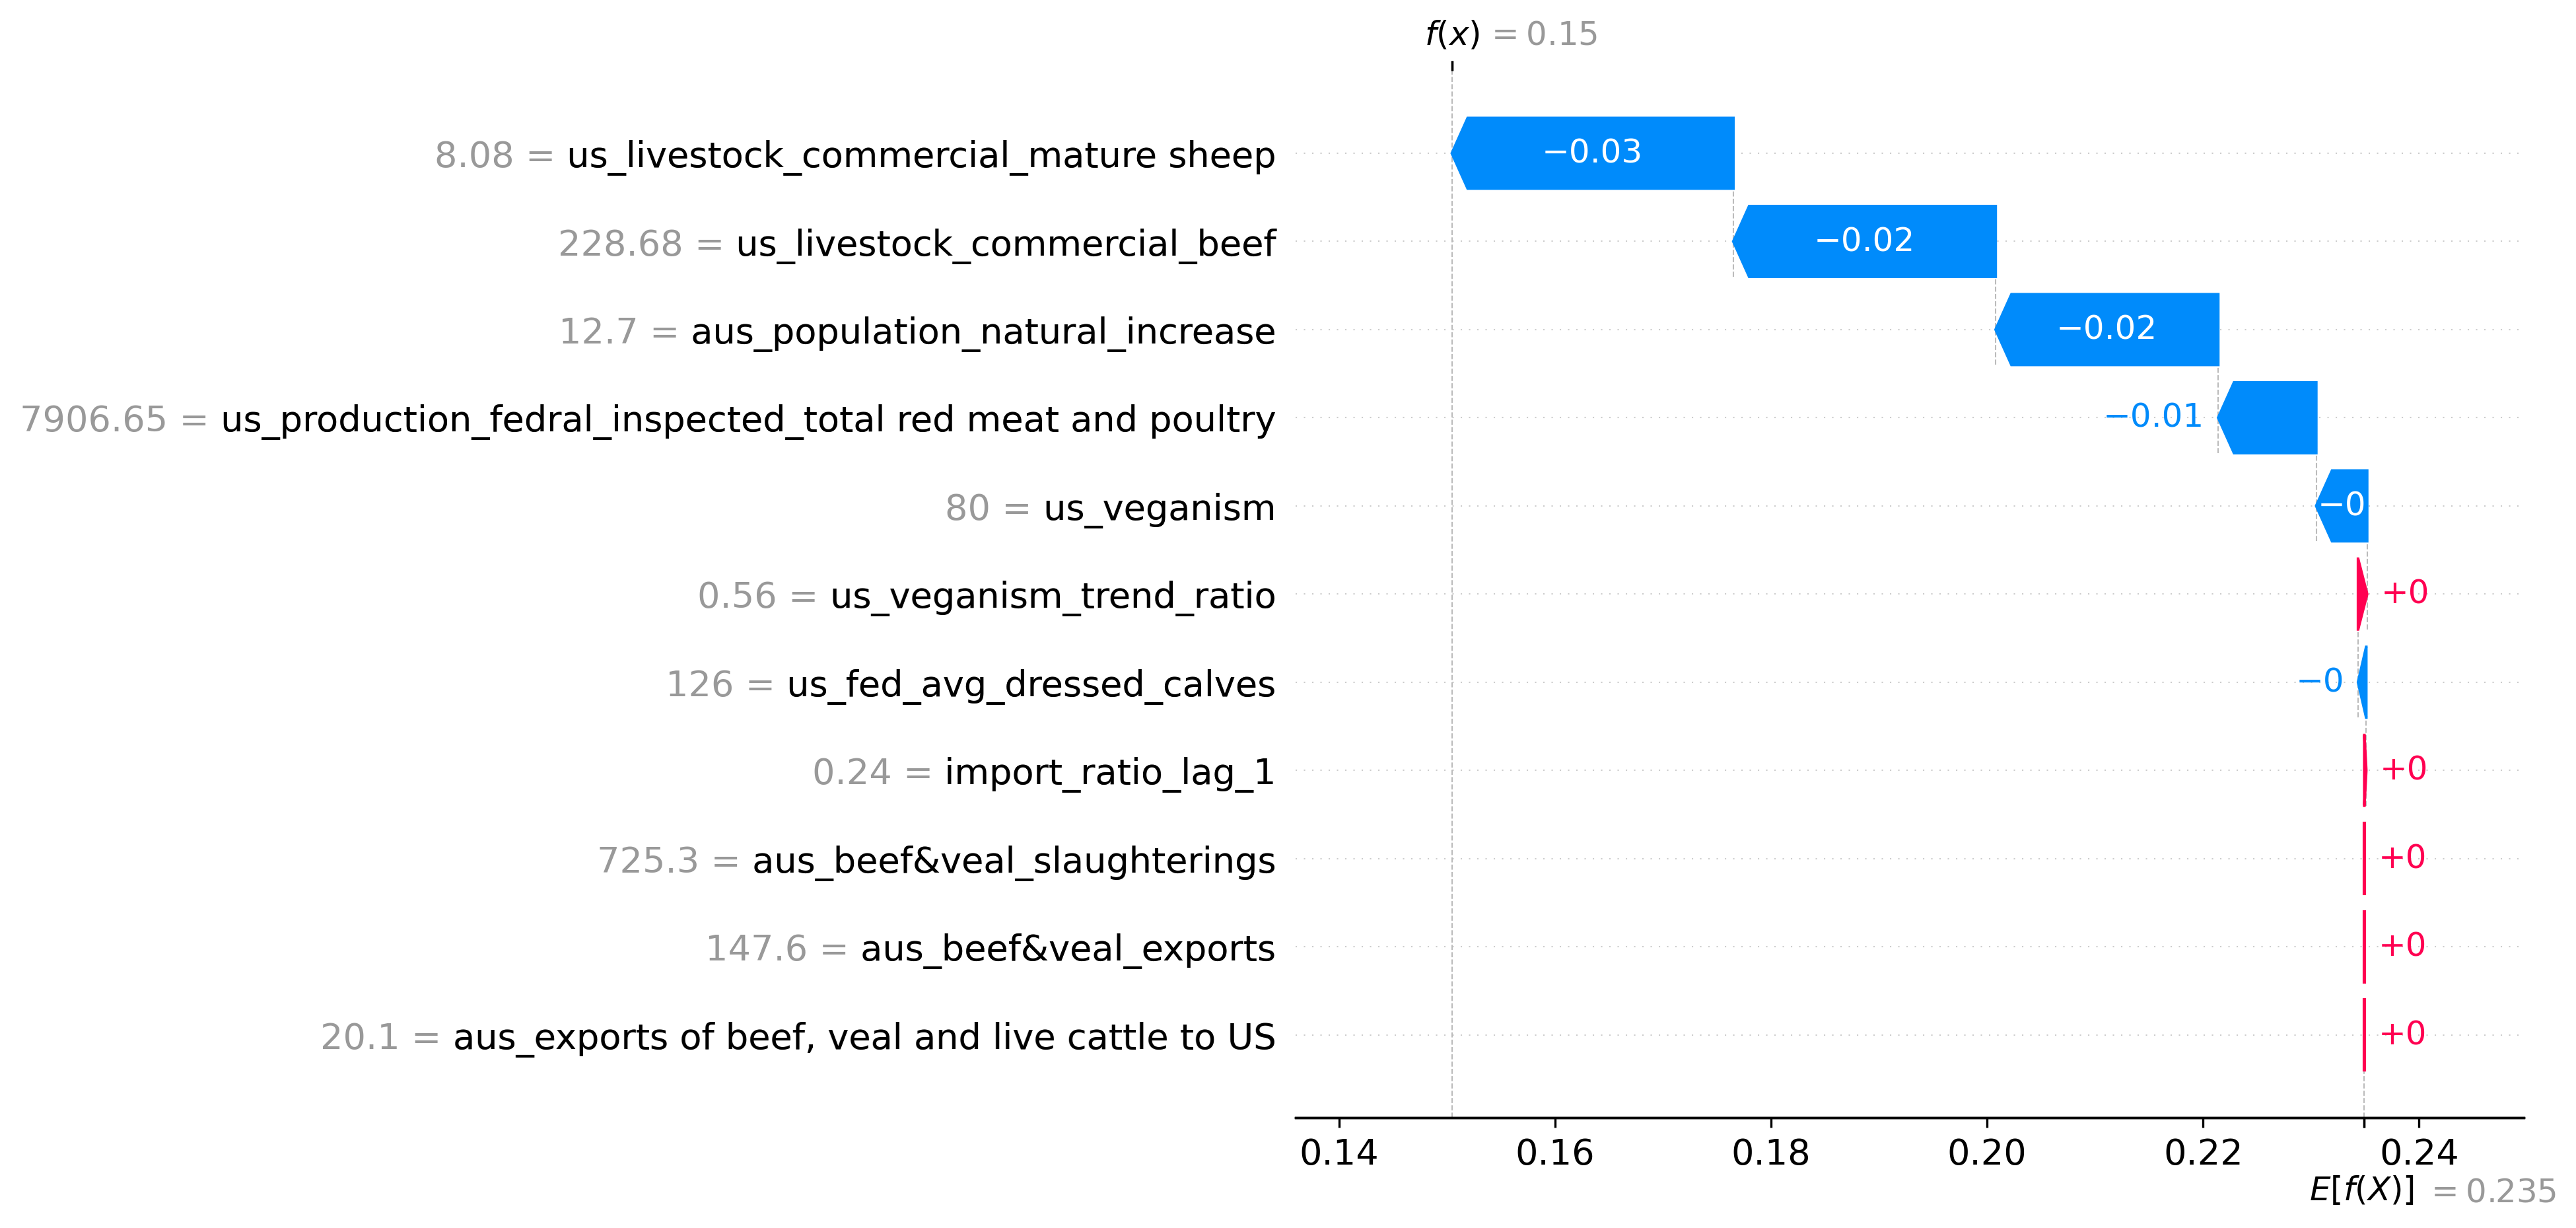

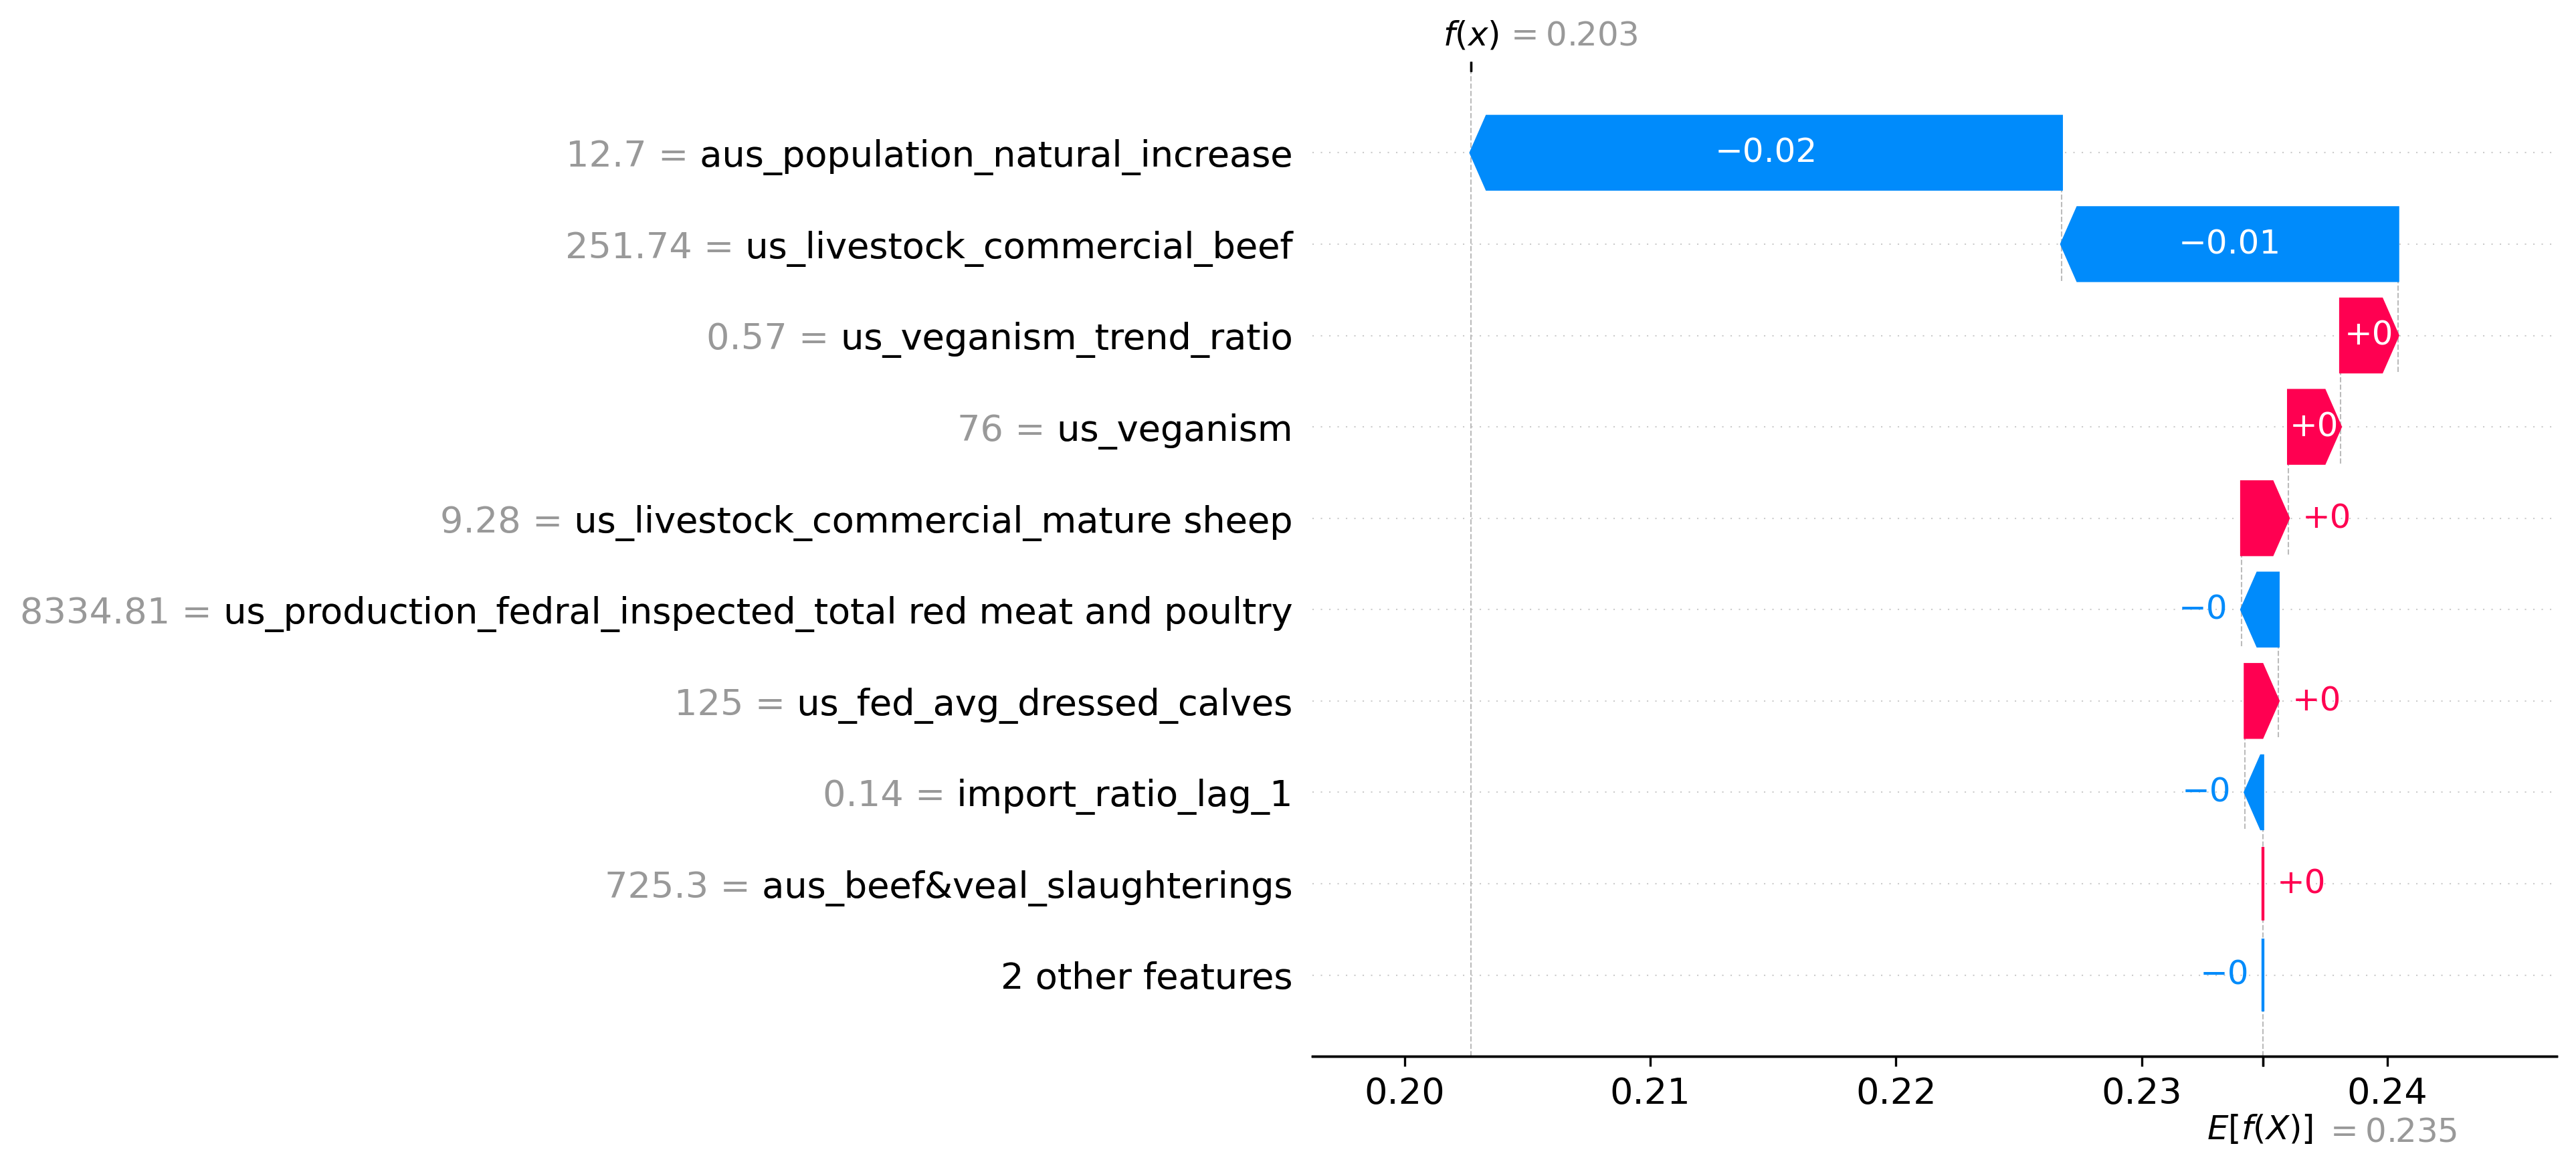

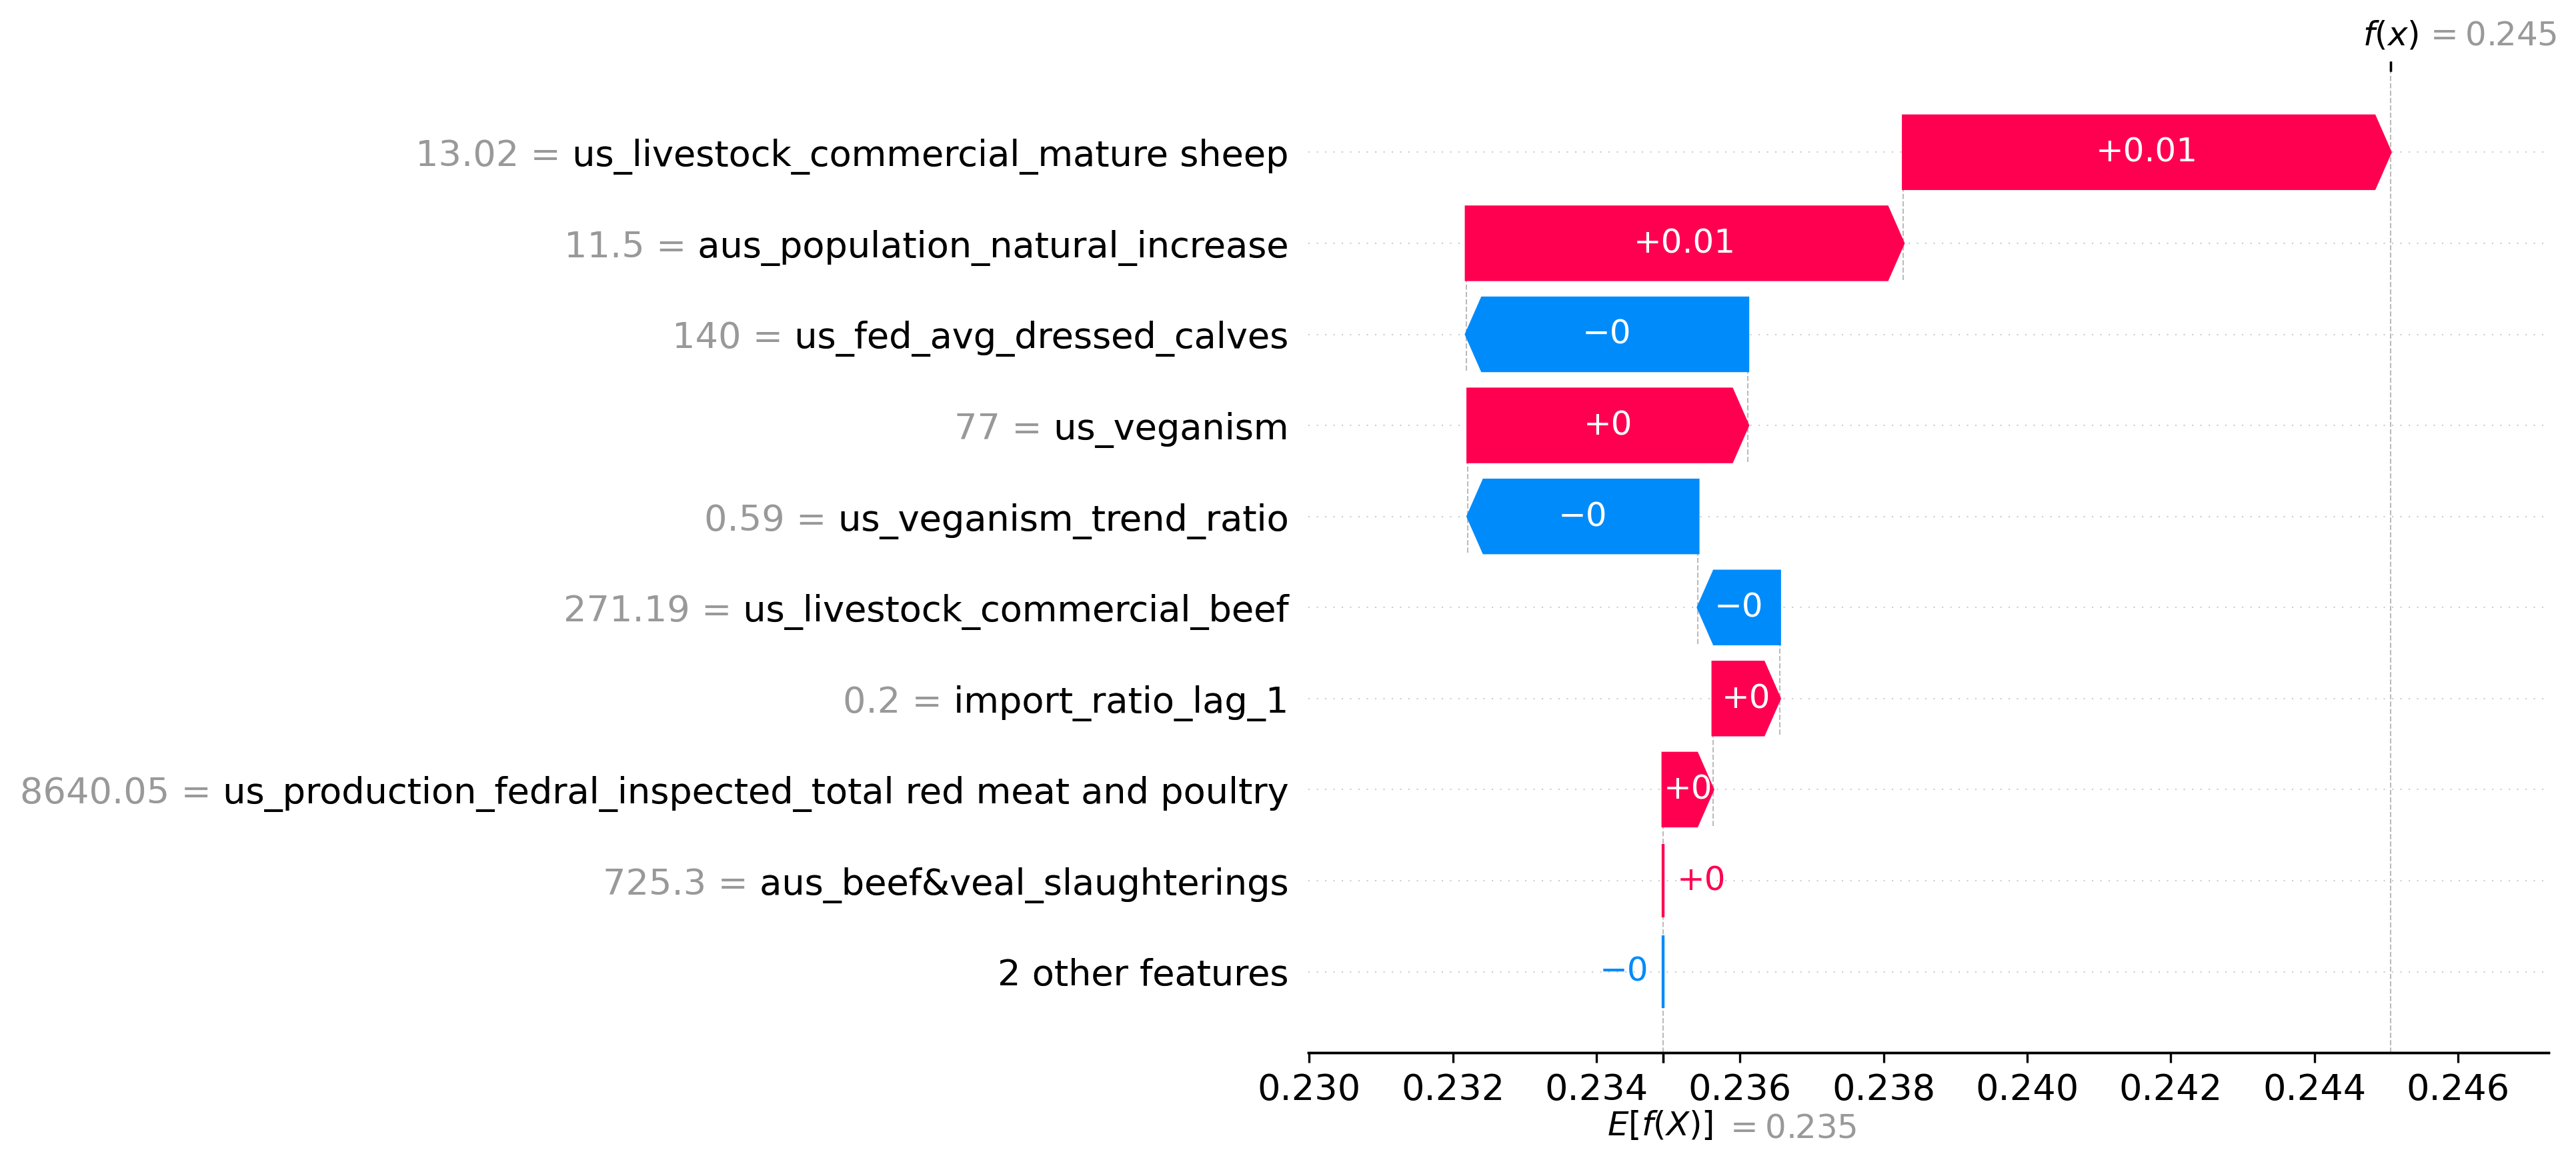

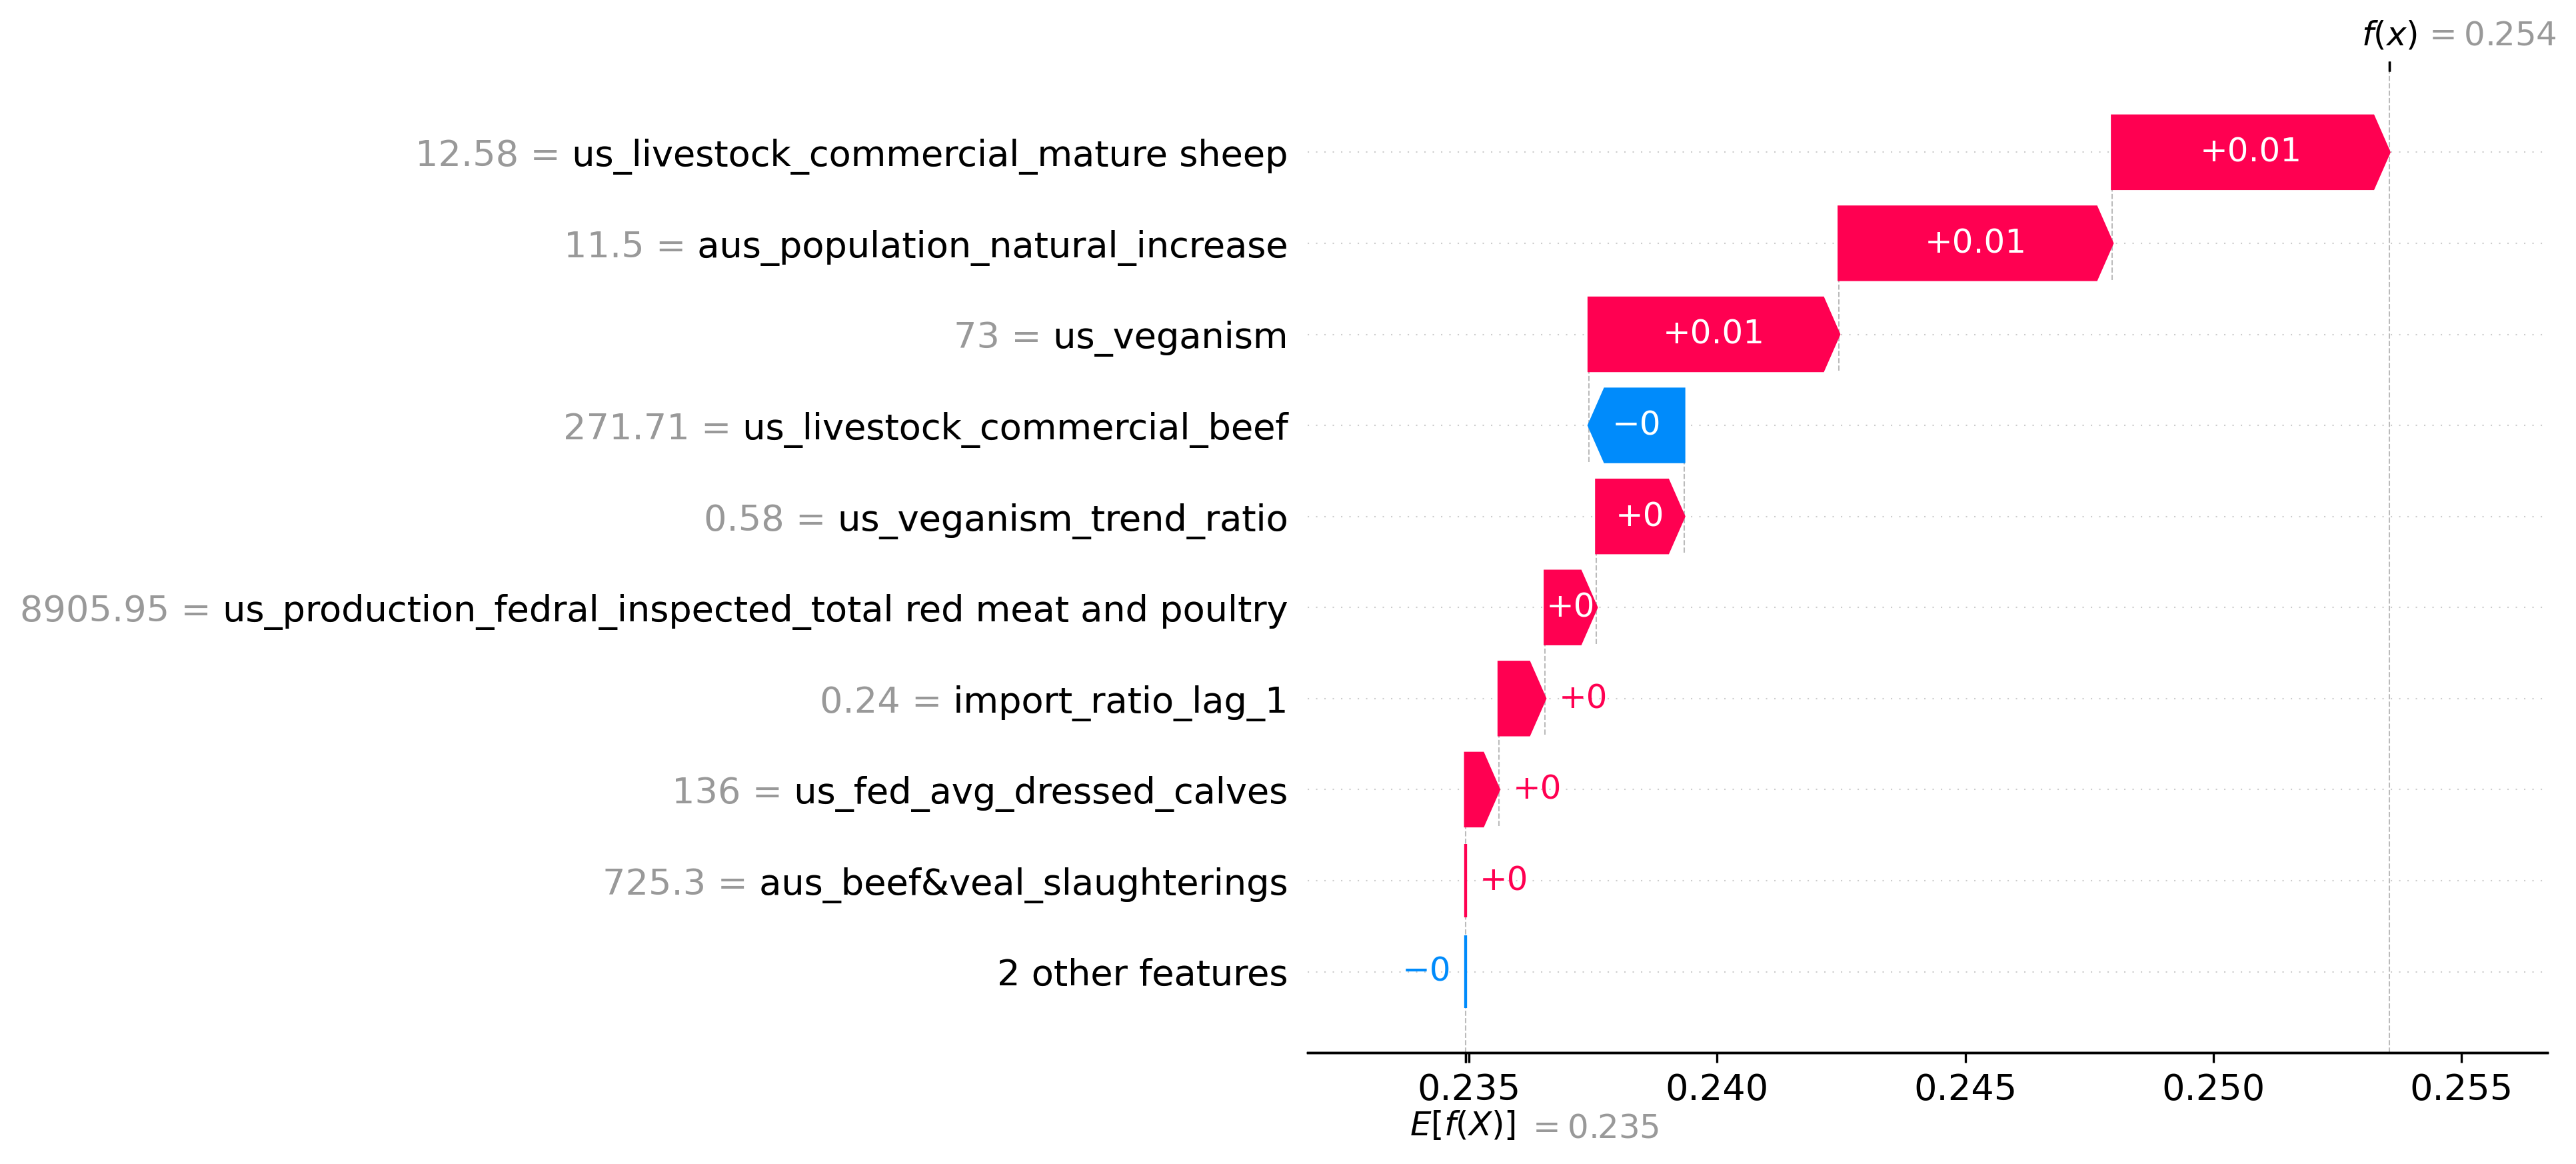

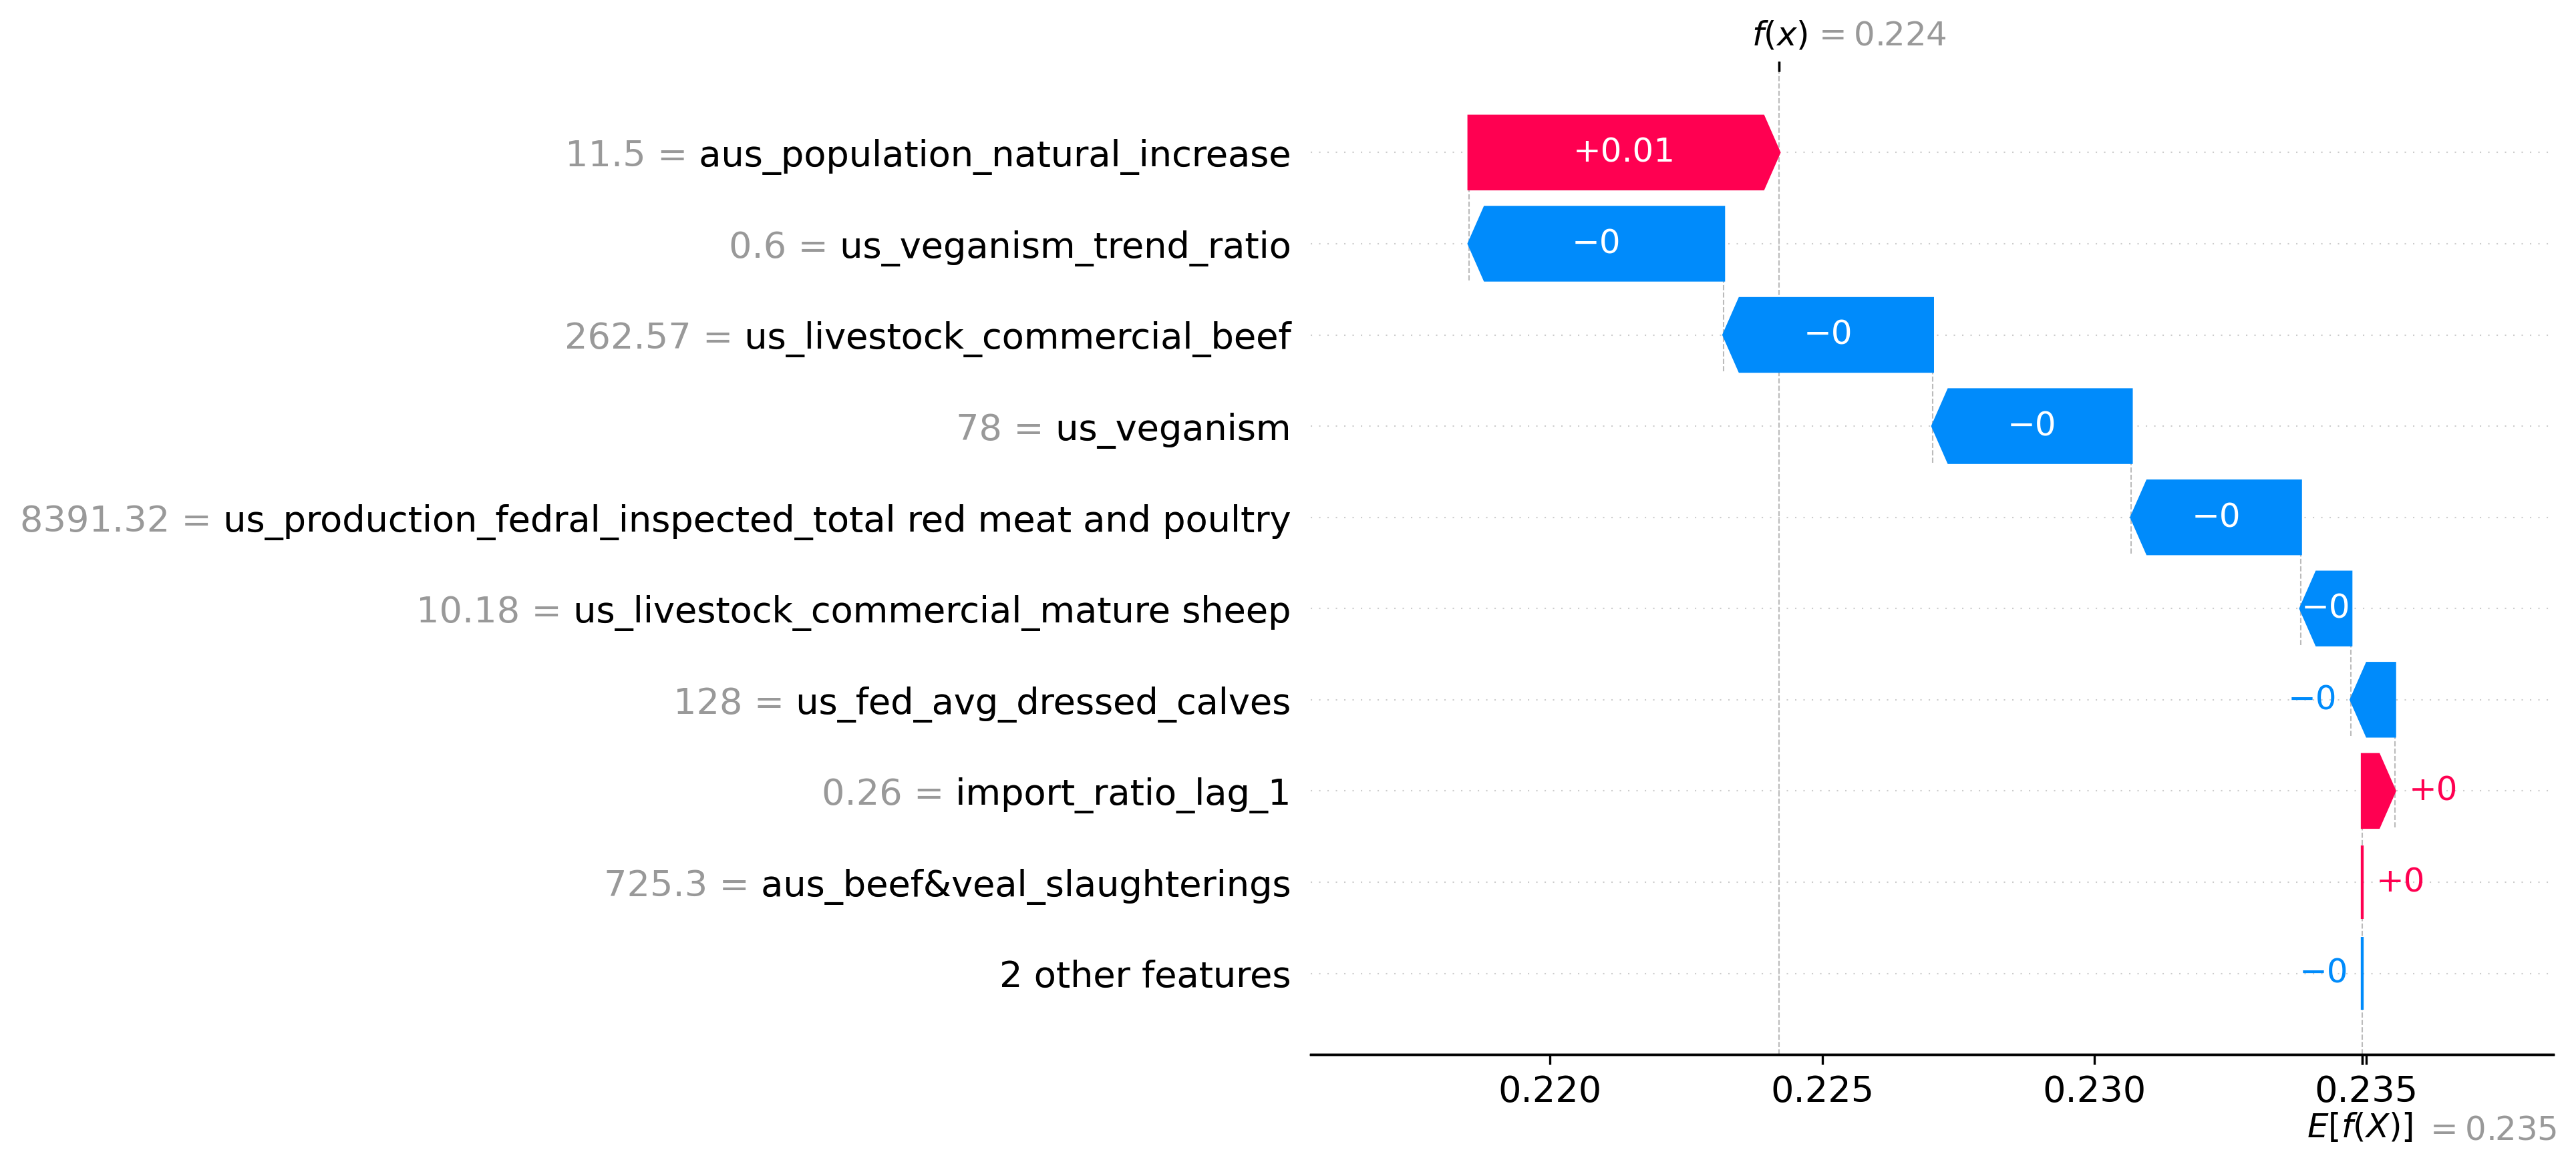

In [53]:
# compute the SHAP values for every prediction in the validation dataset
explainer_has_outlier = shap.TreeExplainer(best_model, best_X_test_lag)
shap_values_has_outlier = explainer_has_outlier(best_X_test_lag)


# visualize the first prediction's explanation

#shap.plots._waterfall.waterfall_legacy(explainer_has_outlier.expected_value, shap_values_has_outlier[0])
#shap.waterfall_plot(explainer_has_outlier.expected_value, shap_values_has_outlier[0,:], feature_names=best_X_test_lag.columns.values)
#shap.plots.waterfall(explainer_has_outlier.expected_value, shap_values_has_outlier.values[11,:], best_X_test_lag.iloc[11,:])
shap.plots.waterfall(shap_values_has_outlier[0], max_display=20, show=True)
shap.plots.waterfall(shap_values_has_outlier[1], max_display=20, show=True)
shap.plots.waterfall(shap_values_has_outlier[2])
shap.plots.waterfall(shap_values_has_outlier[3])
shap.plots.waterfall(shap_values_has_outlier[4])
shap.plots.waterfall(shap_values_has_outlier[5])

In [46]:
shap.force_plot(explainer_has_outlier.expected_value, shap_values_has_outlier.values[1,:], best_X_test_lag.iloc[1,:])

In [47]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[0])


In [48]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[1])

In [49]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[2])

In [50]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[3])

In [51]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[4])

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implmementation the margin output of the model is explained, not the transformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean the import ratio is more likely to increase, while large negative values mean the import ratio is more likely to decrease.

## Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature on a row, where the x-axis is the SHAP value. By doing this for all features, we see which features drive the model's prediction a lot (such as us_total_red meat), and which only effect the prediction a little. Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

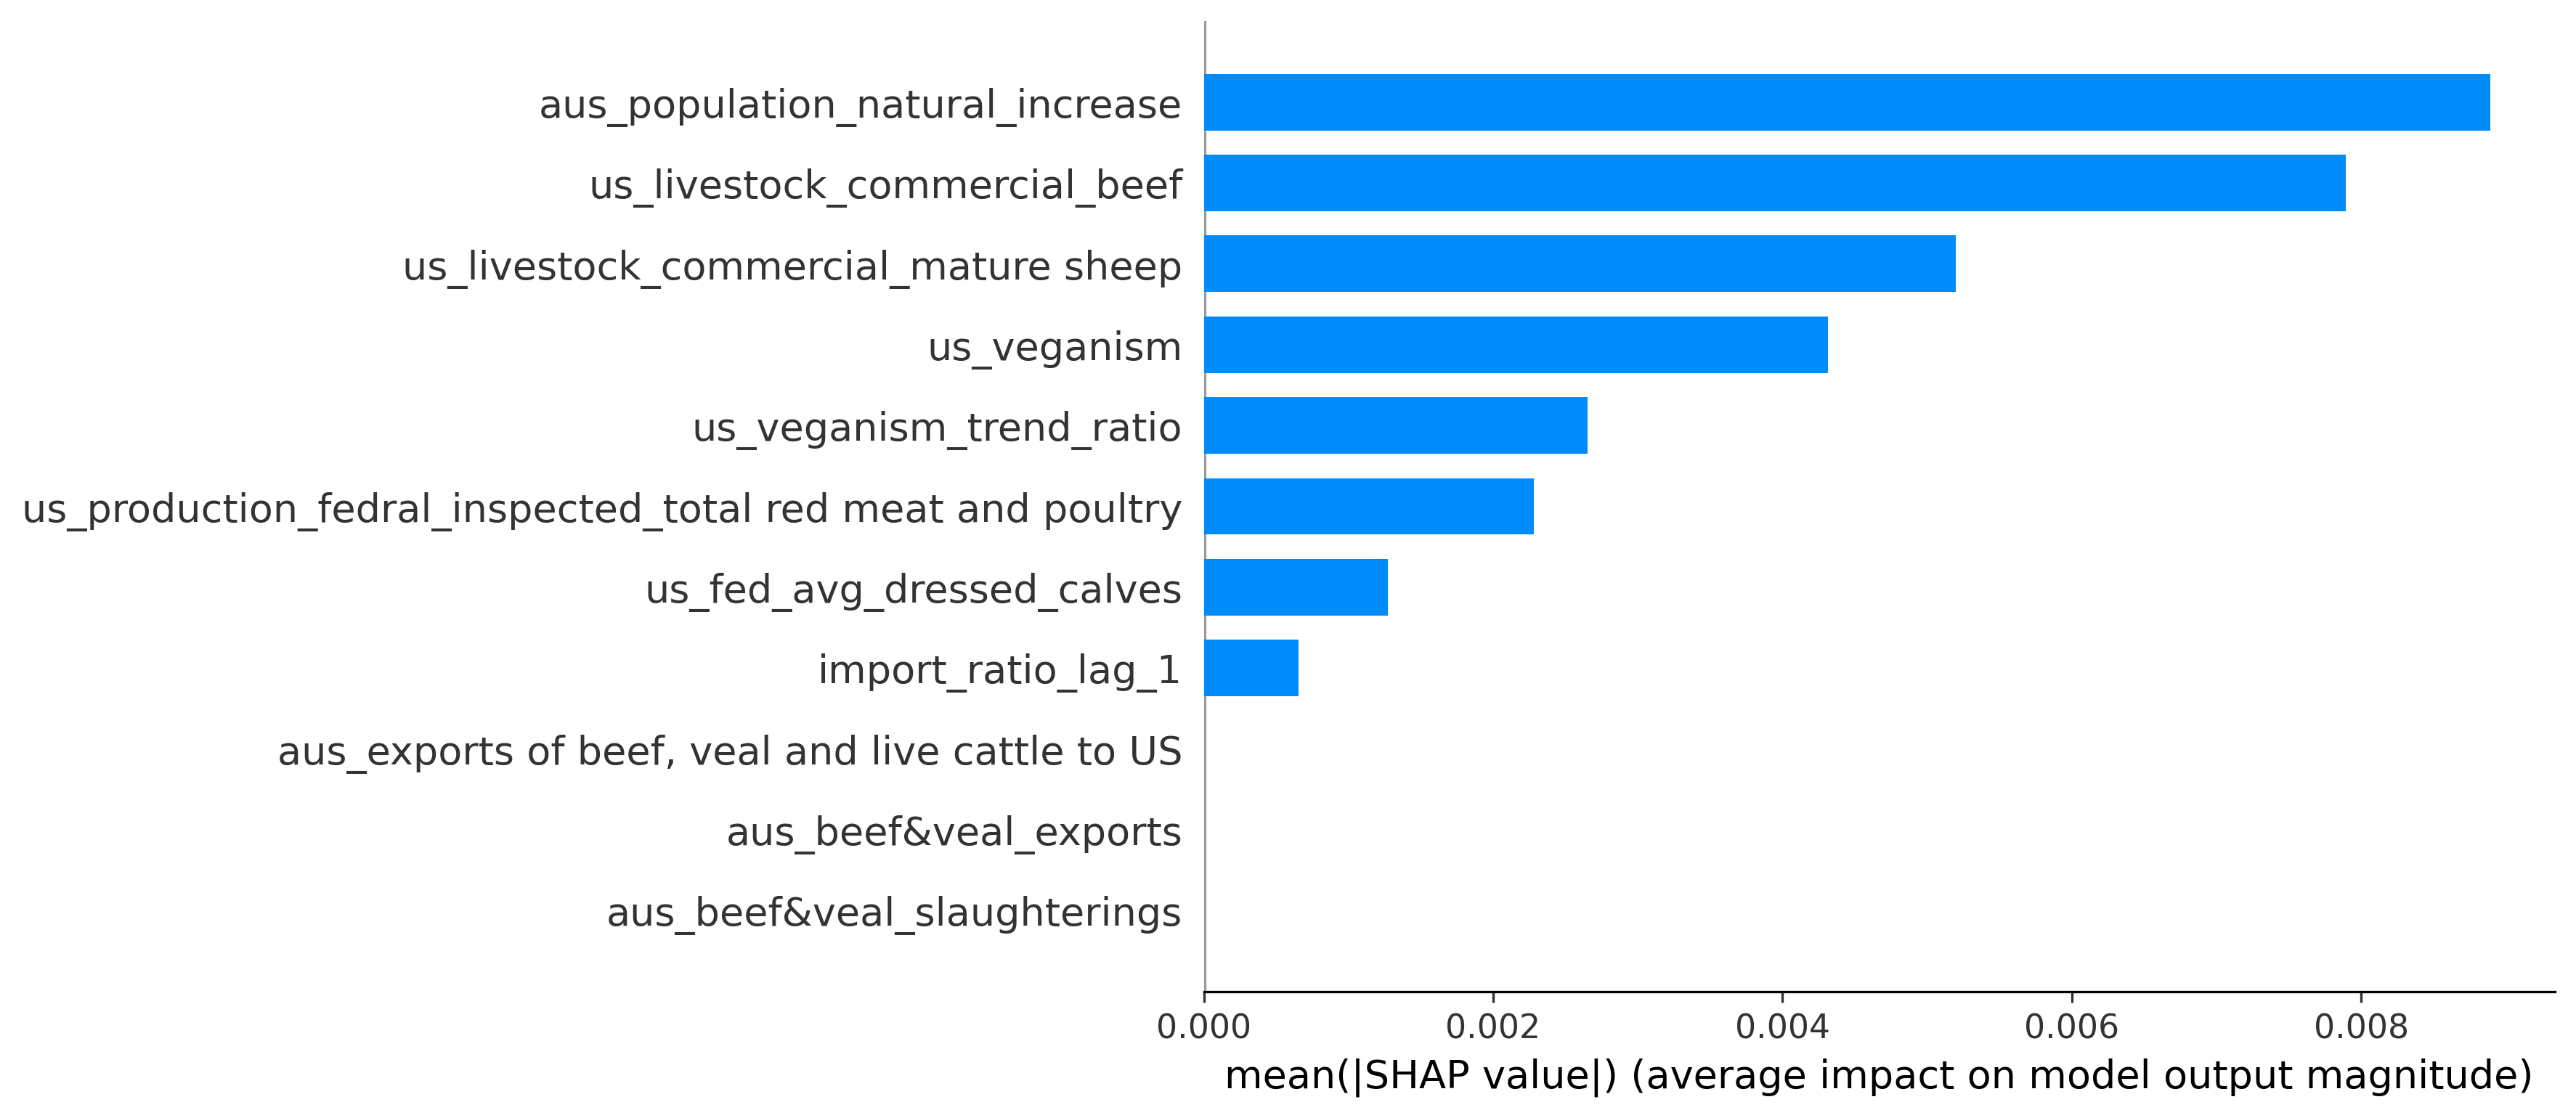

In [52]:
shap.summary_plot(shap_values_has_outlier, best_X_test_lag,plot_type="bar", show=False)
plt.savefig("all_feature_12M_shap_summary_plot.pdf", format='pdf', dpi=1000, bbox_inches='tight')

In [ ]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(model_all_yes, best_X_test_lag)
out1.to_csv("old_12m_shap_rank.csv")

